## Training Section

# Part 1: The Signature Transform/Kernel

In [3]:
#import ksig     #Needs CUDA
import numpy as np
import itertools
import gzip
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
#Data Pre-processing; adapted from signature_features.ipynb and removes mid-price column
def pre_process():
    data = pd.read_csv('./data/data.csv.gz', compression='gzip')
    # set the NaN sizes sizes to zero
    askSize_columns = [f'askSize{i}' for i in range(15)]
    bidSize_columns = [f'bidSize{i}' for i in range(15)]
    size_columns = askSize_columns + bidSize_columns
    data[size_columns] = data[size_columns].fillna(0.0)
    # set the NaN rates to last observed value and fill the remaining ones backward
    askRate_columns = [f'askRate{i}' for i in range(15)]
    bidRate_columns = [f'bidRate{i}' for i in range(15)]
    rate_columns = askRate_columns + bidRate_columns
    #data['midprice'] = 0.5 * (data['askRate0'] + data['bidRate0'])

    # reorder columns
    selected_columns = [[f'askRate{i}', f'bidRate{i}', f'askSize{i}', f'bidSize{i}'] for i in range(15)]
    selected_columns = list(itertools.chain.from_iterable(selected_columns)) #+ ['midprice']
    data = data[selected_columns]
    return data

In [7]:
data = pre_process()
X = data.to_numpy()

Let $\mathcal{P}_\mathcal{X}$ be a set of paths in a topological space $\mathcal{X}$. We define the truncated Signature Kernel up to depth $d$ $k_d^{\oplus}: \mathcal{P}_\mathcal{X} \times \mathcal{P}_\mathcal{X} \rightarrow \mathbb{R}$:  [ksig]
\begin{equation}
    k_d^{\oplus}(x,y) = \langle S(k_x), S(k_y) \rangle
    = \sum_{m = 0}^{d}{\int_{s_1 < ... < s_m, t_1<...<t_m} {\prod^m_{i=1}{d \kappa(s_i, t_i)}} }
\end{equation}

where:
\begin{equation}
    \kappa([s,t] \times [u,v]) = k(x(t), y(v)) - k(x(s),y(v)) - k(x(t),y(u)) + k(x(s),y(u))
\end{equation}

Intuitively, the Signature Kernel computes the pairwise similarity of a collection of paths in signature transform space.

We hence propose an efficient, compact, feature engineering method that leverages the properties of the signature transform in an efficient, scalable method that generalises the notion of autocorrelation for higher-dimensional paths.

In our LOB context, at some time $t$, consider the full $60$-dimensional path of length $L$, $x_L(t)$, from times $[t-L, t]$. We may also consider the time-lagged path of length 87, $x_L(t-k)$, from times $[t-k-L, t-k]$.

We simply consider the similarity of these paths using the aforementioned inner product, i.e. $k_d^{\oplus}(x(t),x(t-k))$, corresponding to the the Kernel entries $K_{12} = K_{21}$.

For increasing $k$, we capture the "autocorrelation" on longer timespans, and hence our similarity decreases. By using an ensemble of $k$ s, we can capture short and long-term volatility. 

An initial attempt was made to use Random Fourier Signature Features to approximate the truncated kernels. The aim was to collect data over various lags to run overnight in ~8 hours - it is hence infeasible to run the kernel on every datapoint.
Under the assumption that the our "autocorrelation" doesn't fluctuate wildly on a timescale of around ~10 steps, we chose to compute the statistic every 10th datapoint and interpolate using a suitable piecewise interpolator.
However, the RFSF method introduced a lot of variability, rendering this assumption invalid and not producing a useful feature.

Our successful attempt computes the exact truncated signature kernel - while this approach is $O(N^2 L^2)$, we deal with $N=2$, $L=87, \lfloor \frac{87}{2} \rfloor, \lfloor \frac{87}{4} \rfloor$ respectively which are small, so this approach is surprisingly faster, and allows us to use a depth of 5 for all features.
We also changed the lags to fractions of 87 - these features will hence deal with mid/quarter intervals of the target.
We also subsample each lag at different intervals based on the timescales of the dynamics - this approach runs in about 8 hours with a much improved acccuracy.

In [ ]:
#Lags are now fractions of 87
ks = [int(87*0.125), int(87*0.25), int(87*0.5), int(87*1), int(87*1.5), int(87*2)]
n_levels = [5, 5, 5, 5, 5, 5]
sub_sample = [1, 2, 5, 1, 5, 3]
L = 87   #Also run for int(87/4),  int(87/2)

N = int(data.shape[0])
sims = np.full([6,len(np.arange(0,N,1))], np.nan)
print(sims.shape)

static_kernel = ksig.static.kernels.RBFKernel()

for i in range(6):
    try:
        for j, t in enumerate(tqdm(np.arange(L + ks[i],N,sub_sample[i]))):  #Delete the ones off the end probably... depends on the gap we leave
            X_window = np.stack((X[t-L:t], X[t-ks[i]-L:t-ks[i]]), axis=0)
            # Instantiate RFF feature map.
            # Instantiate tensor random projections.
            sig_kernel = ksig.kernels.SignatureKernel(n_levels[i], static_kernel=static_kernel)

            # Fit the kernel to the data.
            K_XX = sig_kernel(X_window)

            sims[i,t] = K_XX[0][1]  # K_XX has shape (1000, 1000).
    except:
        print("error")
np.save("sig_kernel.npy", sims)

In [33]:
test = np.load("sig_kernel.npy")
test.shape

(6, 3497666)

In [34]:
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
N = int(data.shape[0])
final = np.full([6,N], np.nan)

for i in range(6):
    x = np.arange(L + ks[i],N, sub_sample[i])
    y = test[i, L + ks[i]:][::sub_sample[i]]
    xx = np.arange(L + ks[i],N,1)
    interp = Akima1DInterpolator(x, y)(xx)
    final[i,L + ks[i]:] = interp

In [53]:
np.save("final_coeffs.npy", final)

We visualise these computed values for $L=87$.

Text(0.5, 0, 't')

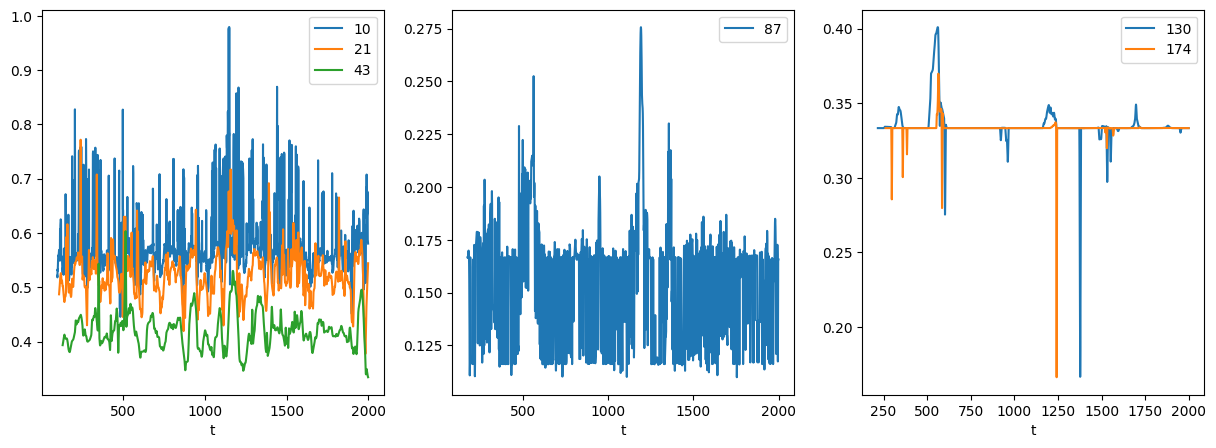

In [22]:
c = np.load("final_coeffs.npy")
ks = [int(87*0.125), int(87*0.25), int(87*0.5), int(87*1), int(87*1.5), int(87*2)]
n_levels = [5, 5, 5, 5, 5, 5]
sub_sample = [1, 2, 5, 1, 5, 3]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
for i in [0,1,2]:
    ax1.plot(c[i,:2000], label=ks[i])
ax1.set_xlabel("t")
ax1.legend()

ax2.plot(c[3,:2000], label=ks[3])
ax2.legend()
ax2.set_xlabel("t")

for i in [4,5]:
    ax3.plot(c[i,:2000], label=ks[i])
ax3.legend()
ax3.set_xlabel("t")

We can observe that as $k$ increases, our statistic picks up longer term variability in our "time series". Combined with varying $L$, we hence gain a good overall picture of variation at a range of time scales.

We also run the signature kernel method as above on the set of financial features for the same values of $L$, (full explanation of these features in section 4)

In [ ]:
#Create lists of core raw features
askRateList = ['askRate' + str(i) for i in range(0,15)]
askSizeList = ['askSize' + str(i) for i in range(0,15)]
bidRateList = ['bidRate' + str(i) for i in range(0,15)]
bidSizeList = ['bidSize' + str(i) for i in range(0,15)]

In [3]:
import ta
def create_limited_features_orig(df: pd.DataFrame):
    # limited features
    df['midRate'] = (df.bidRate0 + df.askRate0) / 2 # necessary for ohlc
    df['OIR'] = (df.bidSize0 - df.askSize0)/(df.bidSize0 + df.askSize0)
    df['totalAskVol'] = df[askSizeList].sum(axis=1)
    df['totalBidVol'] = df[bidSizeList].sum(axis=1)
    df['OIR_total'] = (df.totalBidVol - df.totalAskVol)/(df.totalBidVol + df.totalAskVol)
    
    df['spread'] = df.askRate0 - df.bidRate0
    df['vwaBid'] = np.einsum('ij,ji->i', df[bidRateList], df[bidSizeList].T) / df[bidSizeList].sum(axis=1)
    df['vwaAsk'] = np.einsum('ij,ji->i', df[askRateList], df[askSizeList].T) / df[askSizeList].sum(axis=1)
    df['vwaBidDMid'] = df.midRate - df.vwaBid
    df['vwaAskDMid'] = df.vwaAsk - df.midRate
    df['diff_vwaBidAskDMid'] = df.vwaAskDMid - df.vwaBidDMid
    
    b1, a1 = (df.bidRate0 < df.bidRate0.shift(1)), (df.askRate0 < df.askRate0.shift(1))
    b2, a2 = (df.bidRate0 == df.bidRate0.shift(1)), (df.askRate0 == df.askRate0.shift(1))
    valsB, valsA = [0, (df.bidSize0 - df.bidSize0.shift(1))], [0, (df.askSize0 - df.askSize0.shift(1))]
    df['deltaVBid'] = np.select([b1,b2], valsB, default=df.bidSize0)
    df['deltaVAsk'] = np.select([a1,a2], valsA, default=df.askSize0)
    df['VOI'] = df.deltaVBid - df.deltaVAsk
    
    # Time features
    tsi = [87, 261, 348, 435, 522]
    trix = [87, 174, 348, 435, 522]
    for t in tsi:        df['tsi' + str(t)] = ta.momentum.tsi(df.midRate, window_fast=t, window_slow=2.25*t)
    for t in trix:       df['trix' + str(t)] = ta.trend.trix(df.midRate, window=t)
    df['minaskRate'] = df[['askRate0','askRate1','askRate2','askRate3','askRate4','askRate5','askRate6','askRate7','askRate8','askRate9','askRate10','askRate11','askRate12','askRate13','askRate14']].min(axis=1)
    df['maxbidRate'] = df[['bidRate0','bidRate1','bidRate2','bidRate3','bidRate4','bidRate5','bidRate6','bidRate7','bidRate8','bidRate9','bidRate10','bidRate11','bidRate12','bidRate13','bidRate14']].max(axis=1)

    df['askBidRatio'] = df['minaskRate'] / df['maxbidRate']
    
    df['askNotEqualZero'] = df[['askRate0','askRate1','askRate2','askRate3','askRate4','askRate5','askRate6','askRate7','askRate8','askRate9','askRate10','askRate11','askRate12','askRate13','askRate14']].ne(0).sum(axis=1)
    df['avgaskRate'] = (df['askRate0']*df['askSize0']+df['askRate1']*df['askSize1']+df['askRate2']*df['askSize2']+df['askRate3']*df['askSize3']+df['askRate4']*df['askSize4']+df['askRate5']*df['askSize5']+df['askRate6']*df['askSize6']+df['askRate7']*df['askSize7']+df['askRate8']*df['askSize8']+df['askRate9']*df['askSize9']+df['askRate10']*df['askSize10']+df['askRate11']*df['askSize11']+df['askRate12']*df['askSize12']+df['askRate13']*df['askSize13']+df['askRate14']*df['askSize14'])/df['askNotEqualZero']

# Create a feature 'average bid rate' ('avgbidRate'), where the average is computed after removing zero entries
# 'bidNotEqualZero' is a helper feature that counts the number of non-zero entries, that will be dropped later
    df['bidNotEqualZero'] = df[['bidRate0','bidRate1','bidRate2','bidRate3','bidRate4','bidRate5','bidRate6','bidRate7','bidRate8','bidRate9','bidRate10','bidRate11','bidRate12','bidRate13','bidRate14']].ne(0).sum(axis=1)
    df['avgbidRate'] = (df['bidRate0']*df['bidSize0']+df['bidRate1']*df['bidSize1']+df['bidRate2']*df['bidSize2']+df['bidRate3']*df['bidSize3']+df['bidRate4']*df['bidSize4']+df['bidRate5']*df['bidSize5']+df['bidRate6']*df['bidSize6']+df['bidRate7']*df['bidSize7']+df['bidRate8']*df['bidSize8']+df['bidRate9']*df['bidSize9']+df['bidRate10']*df['bidSize10']+df['bidRate11']*df['bidSize11']+df['bidRate12']*df['bidSize12']+df['bidRate13']*df['bidSize13']+df['bidRate14']*df['bidSize14'])/df['bidNotEqualZero']

# The helper variables are dropped here
    df = df.drop(['askNotEqualZero','bidNotEqualZero', 'minaskRate', 'maxbidRate'], axis=1)
    return df

In [4]:
path = 'data/data.csv.gz'
df = pd.read_csv(path)
df = df.astype('float32')
df.fillna(0, inplace=True)
df.replace([np.inf, -np.inf], np.nan).fillna(0).drop('y', axis=1)
askRateList = ['askRate' + str(i) for i in range(0,15)]
askSizeList = ['askSize' + str(i) for i in range(0,15)]
bidRateList = ['bidRate' + str(i) for i in range(0,15)]
bidSizeList = ['bidSize' + str(i) for i in range(0,15)]
data_aug = create_limited_features_orig(df)

In [13]:
data_aug.fillna(0, inplace=True)
data_aug.replace([np.inf, -np.inf], np.nan).fillna(0).drop('y', axis=1)
X = data_aug.drop(askRateList + askSizeList + bidRateList + bidSizeList, axis=1).to_numpy()
X.shape

(3497666, 28)

In [ ]:
ks = [int(87*0.125), int(87*0.25), int(87*0.5), int(87*1), int(87*1.5), int(87*2)]
n_levels = [5, 4, 4, 5, 3, 3]
sub_sample = [2, 2, 3, 2, 3, 3]
L = 87 #Also run for int(87/4),  int(87/2)

N = int(data_aug.shape[0])
sims = np.full([6,len(np.arange(0,N,1))], np.nan)
print(sims.shape)

static_kernel = ksig.static.kernels.RBFKernel()

for i in range(6):
    try:
        for j, t in enumerate(tqdm(np.arange(L + ks[i],N,sub_sample[i]))):  #Delete the ones off the end probably... depends on the gap we leave
            X_window = np.stack((X[t-L:t], X[t-ks[i]-L:t-ks[i]]), axis=0)
            # Instantiate RFF feature map.
            # Instantiate tensor random projections.
            sig_kernel = ksig.kernels.SignatureKernel(n_levels[i], static_kernel=static_kernel)

            # Fit the kernel to the data.
            K_XX = sig_kernel(X_window)

            sims[i,t] = K_XX[0][1]  # K_XX has shape (1000, 1000).
    except:
        print("error")
np.save('data_new6.npy', sims)

Interpolate as before.

In [ ]:
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
N = 3497666
#test = np.load("data_new6.npy")
test = sims
final = np.full([6,N], np.nan)
ks = [int(87*0.125), int(87*0.25), int(87*0.5), int(87*1), int(87*1.5), int(87*2)]
n_levels = [5, 4, 4, 5, 3, 3]
sub_sample = [2, 2, 3, 2, 3, 3]


for i in range(6):
    try:
        x = np.arange(L + ks[i],N, sub_sample[i])
        y = test[i, L + ks[i]:][::sub_sample[i]]
        print(y)
        xx = np.arange(L + ks[i],N,1)
        interp = Akima1DInterpolator(x, y)(xx)
        final[i,L + ks[i]:] = interp
    except:
        pass

[ksig] Király, F.J. and Oberhauser, H. (2016) ‘Kernels for sequentially ordered data’, arXiv [stat.ML] [Preprint]. Available at: http://arxiv.org/abs/1601.08169.

### Signature Transform Generation

In order to extract signatures we started with the code kindly provided, but found that on our machines it was impossible to run. We quickly realised that truncating beyond the second level would be completely infeasible for such a large dataset without a much higher amount of computation power. We spent some time learning how to parallelise and use generators to increase computational efficiency and avoid excessive memory consumption. In spite of this, for the larger windows with depth 2 still had to be computed in smaller chunks, saved to files and manually stitched together. 

While extracting features we did add a time feature to the dataset as we thought this was sensible in case of some kind of seasonality in the behaviour, under the given assumption that the ticks are uniform. We also considered adding a lead lag transform, but upon testing it on a couple of smaller windows in our model, we found it performed comparably to our raw transforms, so we removed it as it added significant computational complexity, which we were already struggling with due to the high dimensionality of the transform.

With this method, we manage to compute the signature transform at level 5 for windows $10, 20, 50, 87, 100$ at depth 1 and windows $10, 20, 50, 87$ at depth 2 until we hit a memory error.

https://www.sciencedirect.com/science/article/pii/S0167947320302395.

In [ ]:
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import pandas as pd
import itertools
import iisignature
from sklearn.base import BaseEstimator, TransformerMixin


class Augment(BaseEstimator, TransformerMixin):
    def __init__(self, normalize=False, add_time=True, lead_lag=False, basepoint=True, t0=0.0, t1=1.0, lags=[1]):
        self.normalize = normalize
        self.add_time = add_time
        self.lead_lag = lead_lag
        self.basepoint = basepoint
        self.t0, self.t1 = t0, t1
        self.lags = lags

    def fit(self, X):
        return self

    def transform(self, X):
        n_samples, n_timesteps, n_features = X.shape

        # Step 1: Normalize if required
        if self.normalize:
            max_vals = np.max(X, axis=1, keepdims=True)  # Efficiently keep dimensions
            X /= np.where(max_vals != 0, max_vals, 1)   # Avoid division by zero

        # Step 2: Lead-Lag transformation
        if self.lead_lag:
            X_list = [X]
            for lag in self.lags:
                # Create lagged version of X
                X_shifted = np.empty_like(X)
                X_shifted[:, lag:, :] = X[:, :-lag, :]
                X_shifted[:, :lag, :] = X[:, 0:1, :]  # Use broadcasting to fill initial values
                X_list.append(X_shifted)
            X = np.concatenate(X_list, axis=-1)  # Concatenate along the feature axis

        # Step 3: Add time dimension
        if self.add_time:
            # Efficiently create time array for all samples
            time = np.linspace(self.t0, self.t1, n_timesteps, dtype=X.dtype)
            time = np.repeat(time[None, :, None], n_samples, axis=0)
            X = np.concatenate((time, X), axis=-1)  # Add time as the first feature

        # Step 4: Add basepoint
        if self.basepoint:
            basepoint = np.zeros((n_samples, 1, X.shape[-1]), dtype=X.dtype)
            X = np.concatenate((basepoint, X), axis=1)

        return X


class FeatureExtraction(Augment):
    def __init__(self, depth, levels=1, t0=0.0,
                 t1=1.0,
                 lags=[1],
                 level_by_level=False,
                 normalize=False,
                 add_time=True,
                 lead_lag=False,
                 basepoint=False):

        Augment.__init__(self, normalize, add_time, lead_lag, basepoint, t0, t1, lags)
        self.depth = depth
        self.levels = levels
        self.level_by_level = level_by_level

    def transform(self, X):
        X_sig_list = []
        indices = np.arange(self.levels) if self.level_by_level else [None]
        X_midprice = X[:, :, -1:]  # Extract `X_midprice` only once

        for j in indices:
            # Determine start and end indices for slicing
            if j is not None:
                start_idx, end_idx = 4 * j, 4 * (j + 1)
            else:
                start_idx, end_idx = 0, 4 * self.levels

            # Slice `X_window` and concatenate with `X_midprice`
            X_window = np.concatenate([X[:, :, start_idx:end_idx], X_midprice], axis=2)

            # Apply augmentation and signature transform
            X_augment = Augment.transform(self, X_window)  # Use the optimized Augment class
            X_sig = iisignature.sig(X_augment, self.depth)  # Compute signature transform

            X_sig_list.append(X_sig)

        # Concatenate all signature results
        X_out = np.concatenate(X_sig_list, axis=1)
        return X_out


def process_chunk(args):
    """Process a chunk of data for a specific depth and level."""
    chunk, depth, levels = args
    feature_extraction = FeatureExtraction(depth=depth, levels=levels)
    return feature_extraction.transform(chunk)

def extract_signature_features(data, windows, depths, levels_list, leave_out_start, leave_out_end, chunk_size=1000):
    M, N = data.shape

    for window_size in tqdm(windows, desc="Processing windows"):
        for depth in depths:
            for levels in levels_list:
                print(f"Processing window: {window_size}, depth: {depth}, levels: {levels}")

                def generate_chunks():
                    current_chunk = []
                    for i in range(leave_out_start + max(windows), M - leave_out_end):
                        window = data[i - window_size:i, :][None, ...]
                        current_chunk.append(window)
                        if len(current_chunk) == chunk_size:
                            yield np.concatenate(current_chunk, axis=0)
                            current_chunk = []
                    if current_chunk:
                        yield np.concatenate(current_chunk, axis=0)
                # Process generator chunks
                results = []
                if window_size >= 20:
                    print(f"Processing large window size {window_size} sequentially.")
                    for chunk in generate_chunks():
                        results.append(process_chunk((chunk, depth, levels)))
                else:
                    with Pool(cpu_count()) as pool:
                        results = pool.map(process_chunk, [(chunk, depth, levels) for chunk in generate_chunks()])

                # Combine results
                X = np.concatenate(results, axis=0)
                assert not np.isnan(X).any(), "NaNs values found in signature features"

                # Save results
                # print(X.shape)
                np.savez_compressed(f"./pastwindow/from_270_depth_{depth}_levels_{levels}_window_{window_size}", X)
                print(f"Saved batch features for window: {window_size}, depth: {depth}, levels: {levels}")


# usedata = pd.read_csv('./data2/data.csv.gz', compression='gzip')

if __name__ == "__main__":
    # Example usage
    data = pd.read_csv('./data2/data.csv.gz', compression='gzip')# .iloc[3000001:, :] # usedata.iloc[(500000 * (n + 2)) - 198:(500000 * (n + 2)) + 200, :]  # Placeholder data; replace with actual dataset
    askSize_columns = [f'askSize{i}' for i in range(15)]
    bidSize_columns = [f'bidSize{i}' for i in range(15)]
    size_columns = askSize_columns + bidSize_columns
    data[size_columns] = data[size_columns].fillna(0.0)
    # set the NaN rates to last observed value and fill the remaining ones backward
    askRate_columns = [f'askRate{i}' for i in range(15)]
    bidRate_columns = [f'bidRate{i}' for i in range(15)]
    rate_columns = askRate_columns + bidRate_columns
    data['midprice'] = 0.5 * (data['askRate0'] + data['bidRate0'])

    # reorder columns
    selected_columns = [[f'askRate{i}', f'bidRate{i}', f'askSize{i}', f'bidSize{i}'] for i in range(15)]
    selected_columns = list(itertools.chain.from_iterable(selected_columns)) + ['midprice']
    data = data[selected_columns]
    df = data.values
    leave_out_start = 170
    leave_out_end = 0

    windows = [10, 20, 50, 87]
    depths = [2]
    levels_list = [5]

    extract_signature_features(df, windows, depths, levels_list, leave_out_start, leave_out_end)

import iisignature
from sklearn.base import BaseEstimator, TransformerMixin


class Augment(BaseEstimator, TransformerMixin):
    def __init__(self, normalize=False, add_time=True, lead_lag=False, basepoint=True, t0=0.0, t1=1.0, lags=[1]):
        self.normalize = normalize
        self.add_time = add_time
        self.lead_lag = lead_lag
        self.basepoint = basepoint
        self.t0, self.t1 = t0, t1
        self.lags = lags

    def fit(self, X):
        return self

    def transform(self, X):
        n_samples, n_timesteps, n_features = X.shape

        # Step 1: Normalize if required
        if self.normalize:
            max_vals = np.max(X, axis=1, keepdims=True)  # Efficiently keep dimensions
            X /= np.where(max_vals != 0, max_vals, 1)   # Avoid division by zero

        # Step 2: Lead-Lag transformation
        if self.lead_lag:
            X_list = [X]
            for lag in self.lags:
                # Create lagged version of X
                X_shifted = np.empty_like(X)
                X_shifted[:, lag:, :] = X[:, :-lag, :]
                X_shifted[:, :lag, :] = X[:, 0:1, :]  # Use broadcasting to fill initial values
                X_list.append(X_shifted)
            X = np.concatenate(X_list, axis=-1)  # Concatenate along the feature axis

        # Step 3: Add time dimension
        if self.add_time:
            # Efficiently create time array for all samples
            time = np.linspace(self.t0, self.t1, n_timesteps, dtype=X.dtype)
            time = np.repeat(time[None, :, None], n_samples, axis=0)
            X = np.concatenate((time, X), axis=-1)  # Add time as the first feature

        # Step 4: Add basepoint
        if self.basepoint:
            basepoint = np.zeros((n_samples, 1, X.shape[-1]), dtype=X.dtype)
            X = np.concatenate((basepoint, X), axis=1)

        return X


class FeatureExtraction(Augment):
    def __init__(self, depth, levels=1, t0=0.0,
                 t1=1.0,
                 lags=[1],
                 level_by_level=False,
                 normalize=False,
                 add_time=True,
                 lead_lag=False,
                 basepoint=False):

        Augment.__init__(self, normalize, add_time, lead_lag, basepoint, t0, t1, lags)
        self.depth = depth
        self.levels = levels
        self.level_by_level = level_by_level

    def transform(self, X):
        X_sig_list = []
        indices = np.arange(self.levels) if self.level_by_level else [None]
        X_midprice = X[:, :, -1:]  # Extract `X_midprice` only once

        for j in indices:
            # Determine start and end indices for slicing
            if j is not None:
                start_idx, end_idx = 4 * j, 4 * (j + 1)
            else:
                start_idx, end_idx = 0, 4 * self.levels

            # Slice `X_window` and concatenate with `X_midprice`
            X_window = np.concatenate([X[:, :, start_idx:end_idx], X_midprice], axis=2)

            # Apply augmentation and signature transform
            X_augment = Augment.transform(self, X_window)  # Use the optimized Augment class
            X_sig = iisignature.sig(X_augment, self.depth)  # Compute signature transform

            X_sig_list.append(X_sig)

        # Concatenate all signature results
        X_out = np.concatenate(X_sig_list, axis=1)
        return X_out


def process_chunk(args):
    """Process a chunk of data for a specific depth and level."""
    chunk, depth, levels = args
    feature_extraction = FeatureExtraction(depth=depth, levels=levels)
    return feature_extraction.transform(chunk)


def extract_signature_features(data, windows, depths, levels_list, leave_out_start, leave_out_end, chunk_size=1000):
    M, N = data.shape

    for window_size in tqdm(windows, desc="Processing windows"):
        for depth in depths:
            for levels in levels_list:
                print(f"Processing window: {window_size}, depth: {depth}, levels: {levels}")

                def generate_chunks():
                    current_chunk = []
                    for i in range(leave_out_start + max(windows), M - leave_out_end):
                        window = data[i - window_size:i, :][None, ...]
                        current_chunk.append(window)
                        if len(current_chunk) == chunk_size:
                            yield np.concatenate(current_chunk, axis=0)
                            current_chunk = []
                    if current_chunk:
                        yield np.concatenate(current_chunk, axis=0)
                # Process generator chunks
                results = []
                if window_size >= 20:
                    print(f"Processing large window size {window_size} sequentially.")
                    for chunk in generate_chunks():
                        results.append(process_chunk((chunk, depth, levels)))
                else:
                    with Pool(cpu_count()) as pool:
                        results = pool.map(process_chunk, [(chunk, depth, levels) for chunk in generate_chunks()])

                # Combine results
                X = np.concatenate(results, axis=0)
                assert not np.isnan(X).any(), "NaNs values found in signature features"

                # Save results
                # print(X.shape)
                np.savez_compressed(f"./pastwindow/from_270_depth_{depth}_levels_{levels}_window_{window_size}", X)
                print(f"Saved batch features for window: {window_size}, depth: {depth}, levels: {levels}")


# usedata = pd.read_csv('./data2/data.csv.gz', compression='gzip')

if __name__ == "__main__":
    # Example usage
    data = pd.read_csv('./data2/data.csv.gz', compression='gzip')# .iloc[3000001:, :] # usedata.iloc[(500000 * (n + 2)) - 198:(500000 * (n + 2)) + 200, :]  # Placeholder data; replace with actual dataset
    askSize_columns = [f'askSize{i}' for i in range(15)]
    bidSize_columns = [f'bidSize{i}' for i in range(15)]
    size_columns = askSize_columns + bidSize_columns
    data[size_columns] = data[size_columns].fillna(0.0)
    # set the NaN rates to last observed value and fill the remaining ones backward
    askRate_columns = [f'askRate{i}' for i in range(15)]
    bidRate_columns = [f'bidRate{i}' for i in range(15)]
    rate_columns = askRate_columns + bidRate_columns
    data['midprice'] = 0.5 * (data['askRate0'] + data['bidRate0'])

    # reorder columns
    selected_columns = [[f'askRate{i}', f'bidRate{i}', f'askSize{i}', f'bidSize{i}'] for i in range(15)]
    selected_columns = list(itertools.chain.from_iterable(selected_columns)) + ['midprice']
    data = data[selected_columns]
    df = data.values
    leave_out_start = 170
    leave_out_end = 0

    windows = [10, 20, 50, 87, 100]
    depths = [1,2]
    levels_list = [10]

    extract_signature_features(df, windows, depths, levels_list, leave_out_start, leave_out_end)


# Part 2: Machine Learning Exploration

### Random Forest Experiment

We first attempted to train a Random Forest Regressor on the raw LOB dataset:

In [ ]:

X = df.drop('y', axis=1)
Y = df['y']

# (2) Split the dataset into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False) 

In [ ]:
# Training a random forest regressor
# (see https://en.wikipedia.org/wiki/Random_forest and https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
n_estimators = 10
max_depth = 7

from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=n_estimators, n_jobs=4, max_depth=max_depth)

regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=10, n_jobs=4)

In [ ]:
# Store the regressor in a file to be used by for later predictions
import pickle
f = open('forest-regressor-10x7.pckl', 'wb')
pickle.dump(regr, f)
f.close()

In [ ]:
# Evaluate the model by computing the R2 score on the test set
from sklearn.metrics import r2_score
yhat = regr.predict(X_test)
r2_score(y_test, yhat)

0.0016614958793740309

The $R^2$ score is quite poor. This signals that Random Forest Regressor is a poor choice as a model. Also it signals that the raw dataset will need feature engineering in the form of signature transforms or extracting more financial data

### XGBoost Experiment

We now run an experiment where we run XGBoost, a similar ensemble method to the LightGBM model we will ultimately use. We inputted Signature Kernels to test performance. While XGBoost performed similarly in terms of $R^2$ acore on the test , it performed slower. We hence opted to use LightGBM instead.

In [ ]:
def train_xgb_model(params, X_train, y_train, X_val, y_val):
    """Train XGBoost and return (model, R^2) on validation."""
    model = xgb.XGBRegressor(
        booster=params['booster'],
        colsample_bytree=params['colsample_bytree'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        min_child_weight=params['min_child_weight'],
        n_estimators=params['n_estimators'],
        objective=params['objective'],
        subsample=params['subsample'],
        eval_metric = r2_score,
        early_stopping_rounds=50, 
        verbosity=0,
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
    )
    
    y_val_pred = model.predict(X_val)
    r2_val = r2_score(y_val, y_val_pred)
    return model, r2_val

def objective_func(space, X_train, y_train, X_val, y_val):
    """Hyperopt objective. We want to maximize R^2 => minimize (1 - R^2)."""
    _, r2_val = train_xgb_model(space, X_train, y_train, X_val, y_val)
    return {'loss': 1.0 - r2_val, 'status': STATUS_OK}

def tune_and_train(X, y):
    """
    Splits X, y into train/val, runs Hyperopt, returns final model & R^2.
    """
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    trials = Trials()
    best = fmin(
        fn=lambda sp: objective_func(sp, X_tr, y_tr, X_val, y_val),
        space=param_space,
        algo=tpe.suggest,
        max_evals=20, 
        trials=trials
    )
    
    # Convert discrete choices
    best['booster'] = 'dart'  # Ensure that 'dart' is chosen
    best['objective'] = 'reg:squarederror'
    max_depth_values = [3, 4, 5, 6]
    n_estimators_values = [500, 1000, 1500]
    best['max_depth'] = max_depth_values[best['max_depth']]
    best['n_estimators'] = n_estimators_values[best['n_estimators']]

    final_model, final_r2 = train_xgb_model(best, X_tr, y_tr, X_val, y_val)
    return final_model, final_r2, best

### RL Experiment

We tried implementing a Reinforcement learning model on our signature data. This was unsuccessful but it was nonetheless interesting. We chose a DDPG (Deep Deterministic Policy Gradient) algorithm as it is (close to) state of the art, and allows us to use a continuous state space (this is just the input data). The loss function for the critic was the MSE. Originally we tried this on some of the raw signature transform data, but found that the dimensionality of the data was far too high, meaning that the model could never converge. The architecture we used for the NNs in the actor and critic framework were both very simple with only 1 hidden layer - we thought about making the model more complicated structure wise to increase it's expressivity, but this was computationally infeasible with such a large dataset.

After this we thought maybe we could use the signature kernels as a condensed way to carry information about the nature of the path. This helped us reduce the dimensionality of the data for the state space and made a huge improvement to the model. Unfortunately the neural networks we can feasibly handle were not deep enough to express the information properly.

We also implemented a version of DDPG which just outputted a discrete action space (essentially just a Deep Q Network / DQN), hoping that this would reduce the possible error, but for reasons unknown to us this was significantly worse. 

In [ ]:
#DDPG
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random


# Define the Actor Model
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# Define the Critic Model
class Critic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def store(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.float32),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1),
            torch.tensor(next_states, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)


# Define the DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, actor_lr=1e-3, critic_lr=1e-3, gamma=0.99, tau=0.005):
        self.gamma = gamma
        self.tau = tau

        self.actor = Actor(state_dim, action_dim)
        self.target_actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)
        self.target_critic = Critic(state_dim, action_dim)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.replay_buffer = ReplayBuffer(buffer_size=100000, batch_size=64)

        self.update_targets(1.0)

    def update_targets(self, tau):
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def select_action(self, state):
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            return self.actor(state).squeeze(0).numpy()

    def train(self):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states = self.replay_buffer.sample()

        # Update Critic
        next_actions = self.target_actor(next_states)
        target_q_values = self.target_critic(next_states, next_actions)
        expected_q_values = rewards + self.gamma * target_q_values

        q_values = self.critic(states, actions)
        critic_loss = nn.MSELoss()(q_values, expected_q_values.detach())

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update Actor
        actor_loss = -self.critic(states, self.actor(states)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update target networks
        self.update_targets(self.tau)


In [ ]:
#DiscDDPG
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random


# Define the Actor Model for Discrete Actions
class Actor(nn.Module):
    def __init__(self, input_dim, num_actions, hidden_dim=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_actions)  # Outputs logits for discrete actions

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)  # Softmax to produce action probabilities


# Define the Critic Model (Q-value estimation)
class Critic(nn.Module):
    def __init__(self, input_dim, num_actions, hidden_dim=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_actions)  # Outputs Q-values for each action

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Returns Q-values for all actions


# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def store(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),  # Changed to long type for discrete actions
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1),
            torch.tensor(next_states, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)


# Define the DDPG Agent with Custom Discrete Action Set
class DDPGAgent:
    def __init__(self, state_dim, action_set, actor_lr=1e-3, critic_lr=1e-3, gamma=0.99, tau=0.005):
        self.gamma = gamma
        self.tau = tau
        self.action_set = torch.tensor(action_set, dtype=torch.float32)  # Store as tensor for fast indexing
        self.num_actions = len(action_set)

        self.actor = Actor(state_dim, self.num_actions)
        self.target_actor = Actor(state_dim, self.num_actions)
        self.critic = Critic(state_dim, self.num_actions)
        self.target_critic = Critic(state_dim, self.num_actions)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.replay_buffer = ReplayBuffer(buffer_size=100000, batch_size=64)

        self.update_targets(1.0)

    def update_targets(self, tau):
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def select_action(self, state):
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action_probs = self.actor(state)  # Get action probabilities
            action_index = torch.multinomial(action_probs, 1).item()  # Sample from probability distribution
            return self.action_set[action_index].item()  # Map to discrete action value

    def train(self):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states = self.replay_buffer.sample()

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_critic(next_states)  # Get Q-values for next states
            next_action_indices = torch.argmax(self.target_actor(next_states), dim=1, keepdim=True)  # Get best action index
            target_q_values = rewards + self.gamma * next_q_values.gather(1, next_action_indices)

        # Compute current Q-values
        action_indices = torch.tensor([self.action_set.tolist().index(a.item()) for a in actions])  # Convert actions to indices
        q_values = self.critic(states).gather(1, action_indices.unsqueeze(1))

        # Critic loss
        critic_loss = nn.MSELoss()(q_values, target_q_values.detach())

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss (Encourage selecting actions with higher Q-values)
        actor_loss = -self.critic(states).gather(1, self.actor(states).argmax(dim=1, keepdim=True)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update target networks
        self.update_targets(self.tau)


# Part 3: Feature Engineering

Out of all the models we tried, LightGBM gives us the best results for our selection of features. We trained several LightGBMs; the first few train on an augmented dataset consisting of raw data, financial features and signature kernels of the raw data and financial features on various lags up to the target 87, and the last few were trained on signature transforms of the raw data over various windows.

We first leave out the first 270 datapoints of the training data for all models - this is the maximum section to leave out across all our models due to windowing back in time. We also leave out the last 5 datapoints of the test set due to NaNs.

We then split the data into 80:20 train test as per the specification.
Further, we split the initial section into 60% training, 20% validation, 20% blending, with a buffer of 1695 to avoid window leakage from signature kernels and financial statistics.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score
from datetime import datetime, timedelta


In [ ]:
#Load the raw data, replace NaNs with 0s
path = 'data/data.csv.gz'
df = pd.read_csv(path, compression="gzip")
df = df.astype('float32')
df.fillna(0, inplace=True)

In [ ]:
#Create lists of core raw features
askRateList = ['askRate' + str(i) for i in range(0,15)]
askSizeList = ['askSize' + str(i) for i in range(0,15)]
bidRateList = ['bidRate' + str(i) for i in range(0,15)]
bidSizeList = ['bidSize' + str(i) for i in range(0,15)]

Load the signature kernels of the financial features and the raw LOB data as described earlier

In [ ]:
kernels = np.load('final_coeffs.npy')
kernels_finance = np.load('finance_feat_coeff.npy')
kernels_short = np.load('final_halfcoeffs.npy')
kernels_finance_short = np.load('finance_halfcoeff.npy')
kernels_quarter = np.load('final_quartercoeffs.npy')
kernels_finance_quarter = np.load('finance_quartercoeff.npy')

Append these features to the dataset

In [ ]:
#Add the kernels to the dataframe 
for i in range(6):
    df['kernel{i}'.format(i=i)] = kernels[i]
    df['kernel_finance{i}'.format(i=i)] = kernels_finance[i]
for i in range(5):
    df['kernel_short{i}'.format(i=i)] = kernels_short[i]
    df['kernel_finance_short{i}'.format(i=i)] = kernels_finance_short[i]
for i in range(4):
    df['kernel_quarter{i}'.format(i=i)] = kernels_quarter[i]
    df['kernel_finance_quarter{i}'.format(i=i)] = kernels_finance_quarter[i]

In [ ]:
#Train/validation/test split with standardised indices - we had a quite a few issues with indices not lining up between code!
def train_valid_test_split(df):
    set_start = 270
    valid_start = 1679079
    blend_start = 2238706
    test_start = 2798332
    blend_end = test_start - 1695
    set_end = 3497465
    train_df = df[set_start:valid_start].copy()
    valid_df = df[valid_start:blend_start].copy()
    blend_df = df[blend_start:blend_end].copy()
    test_df = df[test_start:set_end].copy()
    return train_df, valid_df,blend_df, test_df
train_df, valid_df, blend_df,  test_df = train_valid_test_split(df)

In [ ]:
core = [*askRateList, *askSizeList, *bidRateList, *bidSizeList]

We take inspiration from Andrey's approach by training a series of models that predict the midprice over a series of targets into the future.

In [ ]:
#Generate the lags and store them
lags = [50, 55, 60, 65, 70, 75, 80, 85, 87]
y_dict = {}
for lag in lags:
    y_dict[lag] = df.y.shift(87 - lag).copy()

### Financial features

We now introduce a selection of financial features: $$\text{MidRate}_0 = \frac{\text{AskRate}_0 + \text{BidRate}_0}{2}$$ $$\text{Spread}_0 = \text{AskRate}_0 - \text{BidRate}_0$$ $$\text{Spread Ratio}_0 = \frac{\text{AskSize}_0 - \text{BidSize}_0}{\text{AskSize}_0 + \text{BidSize}_0}$$ $$\text{Volume Weighted Average Ask} =\sum_{i=0}^{14} \text{AskRate}_i \times \text{AskSize}_i$$ $$\text{Volume Weighted Average Bid} =\sum_{i=0}^{14} \text{BidRate}_i \times \text{BidSize}_i$$ $$\text{Volume Weighted Average Ask MidRate} = \text{Volume Weighted Average Ask} - \text{MidRate}_0$$ $$\text{Volume Weighted Average Bid MidRate} = \text{MidRate}_0 - \text{Volume Weighted Average Bid}$$ $$\text{Volume Weighted Average Difference} = \text{Volume Weighted Average Ask MidRate} -\text{Volume Weighted Average Bid MidRate}$$

Besides these elementary financial features that are linear combinations of the original LOB data, it was also useful to approximate the change in Ask and Bid Size over 1 timestep (the derivative). This is was also added to the Datafame. More importantly, we use this to compute the Value of Investment $$\textbf{VOI}= \Delta \text{Bid} - \Delta \text{Ask}$$ 

Now we also calculate true strength index (TSI) of this dataset which is an indicator commonly used in financial Markets to find trend direction and overbought or oversold conditions. It is a "double smoothed" indicator. This means that a moving average is applied to the data, which in this case is daily momentum  is smoothed again with a second moving average that is longer in span. It is given by the following formula.
$$\text{TSI}(m, r, s) = 100 \frac{\mathbb{M}(\mathbb{M}(m,r),s)}{\mathbb{M}(\mathbb{M}(|m|,r),s)}$$

1. $c_0$ is the closing price of today
2. $m = c_0 - c_1$ is the difference in closing time between yesterday and today
3. $\mathbb{M}(m_0, n) = \frac{2}{n+1}[m_0 - \mathbb{M}(m_1, n)] + \mathbb{M}(m_1, n)$ is the exponential moving average of m over n periods
4. r is smoothing period for momentum, which is set to 2.25s
5. s is smoothing period for smoothed momentum, iterated over [87, 261, 348, 435, 522] in our case

TRIX is also implemented over these windows. It is another financial market indicator that is similar to TSI with a triple smoothed exponential moving average. We use this to also extract the trend direction and overbought or oversold conditions. Both indicators only use past and present financial data.

Implementation of financial features used the package ta, as well as borrowed from Daniel Platt and Glowspint's GitHub.

https://en.wikipedia.org/wiki/TSI

https://www.investopedia.com/articles/technical/02/092402.asp

https://www.maths.ox.ac.uk/system/files/attachments/NUS-LOB19.pdf

https://github.com/danielplatt/XTX-Forecasting-Challenge

https://github.com/glowsplint/xtx

In [ ]:
def Financial_Features(df: pd.DataFrame):
    df['midRate'] = (df.bidRate0 + df.askRate0) / 2 
    
    df['totalAskRate'] = df[askSizeList].sum(axis=1)
    df['totalBidRate'] = df[bidSizeList].sum(axis=1)

    df['Spread_Ratio'] = (df.bidSize0 - df.askSize0)/(df.bidSize0 + df.askSize0)
    df['Spread_total'] = (df.totalBidRate - df.totalAskRate)/(df.totalBidRate + df.totalAskRate)
    df['Spread'] = df.askRate0 - df.bidRate0
    
    df['volume_weighted_averageBid'] = np.einsum('ij,ji->i', df[bidRateList], df[bidSizeList].T) / df[bidSizeList].sum(axis=1)
    df['volume_weighted_averageAsk'] = np.einsum('ij,ji->i', df[askRateList], df[askSizeList].T) / df[askSizeList].sum(axis=1)
    df['volume_weighted_averageBidDMid'] = df.midRate - df.volume_weighted_averageBid
    df['volume_weighted_averageAskDMid'] = df.volume_weighted_averageAsk - df.midRate
    df['diff_vwaBidAskDMid'] = df.volume_weighted_averageAskDMid - df.volume_weighted_averageBidDMid
    
    b1, a1 = (df.bidRate0 < df.bidRate0.shift(1)), (df.askRate0 < df.askRate0.shift(1))
    b2, a2 = (df.bidRate0 == df.bidRate0.shift(1)), (df.askRate0 == df.askRate0.shift(1))
    valsB, valsA = [0, (df.bidSize0 - df.bidSize0.shift(1))], [0, (df.askSize0 - df.askSize0.shift(1))]
    df['deltaBid'] = np.select([b1,b2], valsB, default=df.bidSize0)
    df['deltaAsk'] = np.select([a1,a2], valsA, default=df.askSize0)
    df['VOI'] = df.deltaBid - df.deltaAsk
    
    # Time features
    tsi = [87, 261, 348, 435, 522]
    trix = [87, 174, 348, 435, 522]
    for t in tsi:        df['tsi' + str(t)] = ta.momentum.tsi(df.midRate, window_fast=t, window_slow=2.25*t)
    for t in trix:       df['trix' + str(t)] = ta.trend.trix(df.midRate, window=t)
    df['minaskRate'] = df[['askRate0','askRate1','askRate2','askRate3','askRate4','askRate5','askRate6','askRate7','askRate8','askRate9','askRate10','askRate11','askRate12','askRate13','askRate14']].min(axis=1)
    df['maxbidRate'] = df[['bidRate0','bidRate1','bidRate2','bidRate3','bidRate4','bidRate5','bidRate6','bidRate7','bidRate8','bidRate9','bidRate10','bidRate11','bidRate12','bidRate13','bidRate14']].max(axis=1)

    df['askBidRatio'] = df['minaskRate'] / df['maxbidRate']
    
    df['askNotEqualZero'] = df[['askRate0','askRate1','askRate2','askRate3','askRate4','askRate5','askRate6','askRate7','askRate8','askRate9','askRate10','askRate11','askRate12','askRate13','askRate14']].ne(0).sum(axis=1)
    df['avgaskRate'] = (df['askRate0']*df['askSize0']+df['askRate1']*df['askSize1']+df['askRate2']*df['askSize2']+df['askRate3']*df['askSize3']+df['askRate4']*df['askSize4']+df['askRate5']*df['askSize5']+df['askRate6']*df['askSize6']+df['askRate7']*df['askSize7']+df['askRate8']*df['askSize8']+df['askRate9']*df['askSize9']+df['askRate10']*df['askSize10']+df['askRate11']*df['askSize11']+df['askRate12']*df['askSize12']+df['askRate13']*df['askSize13']+df['askRate14']*df['askSize14'])/df['askNotEqualZero']


    df['bidNotEqualZero'] = df[['bidRate0','bidRate1','bidRate2','bidRate3','bidRate4','bidRate5','bidRate6','bidRate7','bidRate8','bidRate9','bidRate10','bidRate11','bidRate12','bidRate13','bidRate14']].ne(0).sum(axis=1)
    df['avgbidRate'] = (df['bidRate0']*df['bidSize0']+df['bidRate1']*df['bidSize1']+df['bidRate2']*df['bidSize2']+df['bidRate3']*df['bidSize3']+df['bidRate4']*df['bidSize4']+df['bidRate5']*df['bidSize5']+df['bidRate6']*df['bidSize6']+df['bidRate7']*df['bidSize7']+df['bidRate8']*df['bidSize8']+df['bidRate9']*df['bidSize9']+df['bidRate10']*df['bidSize10']+df['bidRate11']*df['bidSize11']+df['bidRate12']*df['bidSize12']+df['bidRate13']*df['bidSize13']+df['bidRate14']*df['bidSize14'])/df['bidNotEqualZero']

# The helper variables are dropped here
    df = df.drop(['askNotEqualZero','bidNotEqualZero', 'minaskRate', 'maxbidRate'], axis=1)
    return df

Augment each portions with financial features - due to buffers, there is no data leakage between train and test.

In [ ]:
df_train2 = Financial_Features(train_df)
df_valid2 = Financial_Features(valid_df)
df_blend2 = Financial_Features(blend_df)
df_test2 = Financial_Features(test_df)

Code for preprocessing the target variable at some lag. We also clip our target to the interval [-3,3], so that our model is more robust to outliers - this in fact universally improves the R^2 score on the validation set!

In [ ]:
def y_preprocess(y):
    set_start = 270
    valid_start = 1679079
    blend_start = 2238706
    test_start = 2798332
    blend_end = test_start - 1695
    set_end = 3497465
    length = set_end - set_start
    y_train = y[set_start:valid_start].copy().values.clip(-3,3)   #Clip predicted ys to make model more robust to outliers
    y_valid = y[valid_start:blend_start].copy().values.clip(-3,3)
    y_blend = y[blend_start:blend_end].copy().values
    y_test = y[test_start:set_end].copy().values
    return y_train, y_valid, y_blend, y_test
y_train_dict= {}
y_valid_dict = {}
y_blend_dict = {}
y_test_dict = {}
for lag in lags:
    y_train_dict[lag], y_valid_dict[lag], y_blend_dict[lag], y_test_dict[lag] = y_preprocess(y_dict[lag])

More preprocessing, replacing infinite values and nans with zeros. Also separates target column for training.

In [ ]:
def preprocess(df):
    x_train = df.replace([np.inf, -np.inf], np.nan).fillna(0).drop('y', axis=1).values
    return x_train

In [ ]:
x_scaled_train = preprocess(df_train2)
x_scaled_valid= preprocess(df_valid2)
x_scaled_blend = preprocess(df_blend2)
x_scaled_test = preprocess(df_test2)

# Part 4: LightGBM Training

For LightGBM, we choose the gbdt boosting type as DART performs slower and gives a comparable $R^2$. Given the dataset's large size, num_leaves and max_depth are chosen to control tree complexity, preventing overfitting while capturing nonlinearities. The learning_rate range ensures a balance between convergence speed and stability. subsample and colsample_bytree introduce randomness to enhance generalization. Regularization terms (reg_alpha, reg_lambda) mitigate overfitting - especially given potential collinearity in financial features. max_bin is adjusted for effective discretization of continuous features. min_split_gain prevents unnecessary splits, and min_data_in_leaf ensures sufficient observations per leaf, which is important for robust predictions in high-dimensional, noisy financial data.

We also use Hyperopt with Bayesian optimisation to efficiently tune the LGBM hyperparameter space on the validation set - this allows us to search with the objective of maximising the $R^2$ score (on the validation set), while balancing exploration/exploitation. We do 30 trials with early stopping if there is no further improvement in 10 iterations to prevent overfitting.

We observe that the $R^2$ score initially starts high for short prediction windows as expected, and decreases as we predict further into the future. However, we observe a jump in performance when we reach the target 87 - this is likely as some added features are conditioned to detect temporal phenomena over lags of 87.

In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.preprocessing import StandardScaler
from hyperopt.early_stop import no_progress_loss
import joblib


# Step 1: Define the Hyperparameter Space for LGBM
param_space = {
    'num_leaves': hp.choice('num_leaves', [20, 40, 60, 80, 100, 120,140]),  # Max leaves in one tree
    'max_depth': hp.quniform('max_depth', 3, 7, 1),  # Depth of the tree
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.06),
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Fraction of samples to be used for fitting
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),  # Fraction of features to be used
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),  # L1 regularization
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),  # L2 regularization
    'max_bin': hp.quniform('max_bin', 50, 90, 1),  # Max number of bins that feature values will be bucketed in
    'min_split_gain': hp.uniform('min_split_gain', 0.5, 1.0),  # Minimum loss reduction required to make a further partition
    'min_data_in_leaf': hp.choice('min_data_in_leaf', [50, 100, 250, 500]),

}

# Step 2: Define the objective function for Hyperopt
def objective(params, x_scaled_train, y_train, x_scaled_valid, y_valid):
    """
    The objective function which takes in hyperparameters and outputs the negative R^2 score
    (since Hyperopt minimizes the objective function, we negate the R^2 score to maximize it).
    """
    # Use fixed params and best hyperparameters from Hyperopt
    fixed_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'metric': 'rmse',
        'verbosity': -1,
        'n_jobs': -1
    }

    params['max_depth'] = int(params['max_depth'])
    params['max_bin'] = int(params['max_bin'])

    # Combine fixed params and the params from Hyperopt
    model_params = {**params, **fixed_params}
    
    # Train model using the current set of hyperparameters
    model = lgb.LGBMRegressor(**model_params)
    model.fit(x_scaled_train, y_train, 
              eval_set=[(x_scaled_valid, y_valid)], 
              eval_metric='r2'
              )

    # Predict on the validation set and calculate R^2 score
    y_pred = model.predict(x_scaled_valid)
    r2 = r2_score(y_valid, y_pred)

    # Since we want to maximize R^2, we return negative R^2 (Hyperopt minimizes the objective)
    return {'loss': 1 - r2, 'status': STATUS_OK}



We now train a LightGBM model for each lag and print the $R^2$ score on the validation and training sets at the end of the hyperparameter tuning.

In [ ]:
for lag in lags:
    print(f"Training model for lag = {lag}")
    y_train = y_train_dict[lag]
    y_valid = y_valid_dict[lag]
    y_test = y_test_dict[lag]

    trials = Trials()
    best = fmin(fn=lambda sp: objective(sp, x_scaled_train, y_train , x_scaled_valid, y_valid),
                space=param_space,
                algo=tpe.suggest,
                max_evals=30,
                trials=trials,
                early_stop_fn=no_progress_loss(10),
    )

    # The best hyperparameters found by Hyperopt
    print("Best hyperparameters:", best)
    print("Trials:", trials)
    print("R2:", 1 - trials.best_trial['result']['loss'])

    best['min_data_in_leaf'] = [50, 100, 250, 500][best['min_data_in_leaf']]
    best['num_leaves'] = [20, 40, 60, 80, 100, 120, 140][best['num_leaves']]
    best['max_depth'] = int(best['max_depth'])
    best['max_bin'] = int(best['max_bin'])

    fixed_params = {'boosting_type': 'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'metric': 'rmse',
        'verbosity': -1,
        'n_jobs': -1}

    lgbm = lgb.LGBMRegressor(**fixed_params, **best, eval_set=(x_scaled_valid, y_valid), eval_metric='r2').fit(x_scaled_train, y_train)
    model_filename = f'models/lgb_lag{lag}.pkl'
    joblib.dump(lgbm, model_filename)

    predictions_train = lgbm.predict(x_scaled_train)
    train_score = r2_score(y_train, predictions_train)
    predictions_valid = lgbm.predict(x_scaled_valid)
    valid_score = r2_score(y_valid, predictions_valid)
    print(f'{train_score:.4f}, {valid_score:.4f}')
    

Training model for lag = 50
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 1/30 [00:12<05:48, 12.00s/trial, best loss: 0.8756521658599669]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 2/30 [00:21<04:48, 10.30s/trial, best loss: 0.8756521658599669]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 3/30 [00:30<04:25,  9.84s/trial, best loss: 0.8756521658599669]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 4/30 [00:40<04:15,  9.83s/trial, best loss: 0.8756521658599669]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 17%|█▋        | 5/30 [00:54<04:48, 11.55s/trial, best loss: 0.8376800824149293]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 20%|██        | 6/30 [01:02<04:06, 10.27s/trial, best loss: 0.8376800824149293]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 23%|██▎       | 7/30 [01:13<04:00, 10.47s/trial, best loss: 0.8376800824149293]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 27%|██▋       | 8/30 [01:23<03:44, 10.19s/trial, best loss: 0.8376800824149293]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 30%|███       | 9/30 [01:34<03:41, 10.56s/trial, best loss: 0.8376800824149293]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 10/30 [01:48<03:55, 11.76s/trial, best loss: 0.8376800824149293]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 11/30 [01:59<03:35, 11.36s/trial, best loss: 0.8376800824149293]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 40%|████      | 12/30 [02:09<03:18, 11.05s/trial, best loss: 0.8376800824149293]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 43%|████▎     | 13/30 [02:21<03:13, 11.38s/trial, best loss: 0.8376800824149293]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 14/30 [02:33<03:01, 11.37s/trial, best loss: 0.8370381502365221]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 15/30 [02:41<02:36, 10.42s/trial, best loss: 0.8370381502365221]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 16/30 [02:51<02:23, 10.24s/trial, best loss: 0.8370381502365221]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 17/30 [03:05<02:27, 11.38s/trial, best loss: 0.8370381502365221]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 60%|██████    | 18/30 [03:16<02:16, 11.39s/trial, best loss: 0.8370381502365221]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 63%|██████▎   | 19/30 [03:25<01:58, 10.76s/trial, best loss: 0.8370381502365221]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 67%|██████▋   | 20/30 [03:36<01:47, 10.72s/trial, best loss: 0.8370381502365221]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 70%|███████   | 21/30 [03:50<01:44, 11.65s/trial, best loss: 0.8370381502365221]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 73%|███████▎  | 22/30 [04:02<01:33, 11.73s/trial, best loss: 0.8344597201345431]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 77%|███████▋  | 23/30 [04:12<01:19, 11.34s/trial, best loss: 0.8344597201345431]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 80%|████████  | 24/30 [04:25<01:10, 11.68s/trial, best loss: 0.8329319261763407]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 83%|████████▎ | 25/30 [04:35<00:56, 11.37s/trial, best loss: 0.8329319261763407]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 87%|████████▋ | 26/30 [04:46<00:44, 11.13s/trial, best loss: 0.8329319261763407]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 90%|█████████ | 27/30 [04:57<00:33, 11.23s/trial, best loss: 0.8329319261763407]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 93%|█████████▎| 28/30 [05:10<00:23, 11.51s/trial, best loss: 0.8329319261763407]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 97%|█████████▋| 29/30 [05:21<00:11, 11.40s/trial, best loss: 0.8329319261763407]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



100%|██████████| 30/30 [05:32<00:00, 11.09s/trial, best loss: 0.8329319261763407]
Best hyperparameters: {'colsample_bytree': np.float64(0.426292227288799), 'learning_rate': np.float64(0.05552239722773201), 'max_bin': np.float64(55.0), 'max_depth': np.float64(7.0), 'min_data_in_leaf': np.int64(0), 'min_split_gain': np.float64(0.8128948463540139), 'num_leaves': np.int64(4), 'reg_alpha': np.float64(0.5297392807121759), 'reg_lambda': np.float64(0.8759738915452808), 'subsample': np.float64(0.7903507508906192)}
Trials: <hyperopt.base.Trials object at 0x1054ee2f0>
R2: 0.1670680738236593


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.2239, 0.1671
Training model for lag = 55
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 1/30 [00:11<05:22, 11.12s/trial, best loss: 0.9066336672201677]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 2/30 [00:20<04:37,  9.90s/trial, best loss: 0.9066336672201677]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 3/30 [00:29<04:15,  9.45s/trial, best loss: 0.9066336672201677]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 4/30 [00:38<04:05,  9.43s/trial, best loss: 0.9066336672201677]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 17%|█▋        | 5/30 [00:52<04:35, 11.03s/trial, best loss: 0.877439886532963] 

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 20%|██        | 6/30 [01:01<04:06, 10.25s/trial, best loss: 0.877439886532963]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 23%|██▎       | 7/30 [01:12<04:04, 10.65s/trial, best loss: 0.877439886532963]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 27%|██▋       | 8/30 [01:22<03:49, 10.44s/trial, best loss: 0.877439886532963]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 30%|███       | 9/30 [01:33<03:41, 10.56s/trial, best loss: 0.877439886532963]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 10/30 [01:48<04:00, 12.02s/trial, best loss: 0.877439886532963]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 11/30 [01:59<03:44, 11.80s/trial, best loss: 0.877439886532963]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 40%|████      | 12/30 [02:11<03:29, 11.63s/trial, best loss: 0.877439886532963]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 43%|████▎     | 13/30 [02:23<03:23, 11.95s/trial, best loss: 0.877439886532963]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 14/30 [02:34<03:04, 11.55s/trial, best loss: 0.8736195407454354]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 15/30 [02:43<02:39, 10.67s/trial, best loss: 0.8736195407454354]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 16/30 [02:54<02:30, 10.76s/trial, best loss: 0.8736195407454354]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 17/30 [03:07<02:30, 11.57s/trial, best loss: 0.8736195407454354]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 60%|██████    | 18/30 [03:18<02:17, 11.42s/trial, best loss: 0.8736195407454354]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 63%|██████▎   | 19/30 [03:28<01:59, 10.84s/trial, best loss: 0.8736195407454354]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 67%|██████▋   | 20/30 [03:39<01:49, 10.99s/trial, best loss: 0.8736195407454354]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 70%|███████   | 21/30 [03:52<01:44, 11.61s/trial, best loss: 0.8736195407454354]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 73%|███████▎  | 22/30 [04:03<01:32, 11.52s/trial, best loss: 0.8728877381313691]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 77%|███████▋  | 23/30 [04:14<01:18, 11.24s/trial, best loss: 0.8728877381313691]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 80%|████████  | 24/30 [04:26<01:09, 11.54s/trial, best loss: 0.871254991669463] 

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 83%|████████▎ | 25/30 [04:37<00:57, 11.41s/trial, best loss: 0.871254991669463]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 87%|████████▋ | 26/30 [04:48<00:44, 11.11s/trial, best loss: 0.871254991669463]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 90%|█████████ | 27/30 [04:58<00:33, 11.00s/trial, best loss: 0.871254991669463]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 93%|█████████▎| 28/30 [05:12<00:23, 11.79s/trial, best loss: 0.871254991669463]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 97%|█████████▋| 29/30 [05:23<00:11, 11.59s/trial, best loss: 0.871254991669463]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



100%|██████████| 30/30 [05:35<00:00, 11.17s/trial, best loss: 0.871254991669463]
Best hyperparameters: {'colsample_bytree': np.float64(0.426292227288799), 'learning_rate': np.float64(0.05552239722773201), 'max_bin': np.float64(55.0), 'max_depth': np.float64(7.0), 'min_data_in_leaf': np.int64(0), 'min_split_gain': np.float64(0.8128948463540139), 'num_leaves': np.int64(4), 'reg_alpha': np.float64(0.5297392807121759), 'reg_lambda': np.float64(0.8759738915452808), 'subsample': np.float64(0.7903507508906192)}
Trials: <hyperopt.base.Trials object at 0x117c28730>
R2: 0.12874500833053704


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.1927, 0.1287
Training model for lag = 60
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 1/30 [00:10<05:15, 10.89s/trial, best loss: 0.9308315905059557]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 2/30 [00:21<05:00, 10.74s/trial, best loss: 0.9308315905059557]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 3/30 [00:31<04:42, 10.48s/trial, best loss: 0.9308315905059557]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 4/30 [00:42<04:34, 10.54s/trial, best loss: 0.9308315905059557]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 17%|█▋        | 5/30 [00:56<04:55, 11.82s/trial, best loss: 0.9079337099775578]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 20%|██        | 6/30 [01:04<04:11, 10.49s/trial, best loss: 0.9079337099775578]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 23%|██▎       | 7/30 [01:16<04:11, 10.94s/trial, best loss: 0.9079337099775578]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 27%|██▋       | 8/30 [01:26<03:59, 10.87s/trial, best loss: 0.9079337099775578]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 30%|███       | 9/30 [01:38<03:52, 11.06s/trial, best loss: 0.9079337099775578]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 10/30 [01:54<04:13, 12.65s/trial, best loss: 0.9079337099775578]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 11/30 [02:06<03:56, 12.47s/trial, best loss: 0.9079337099775578]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 40%|████      | 12/30 [02:17<03:36, 12.01s/trial, best loss: 0.9079337099775578]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 43%|████▎     | 13/30 [02:29<03:24, 12.05s/trial, best loss: 0.9079337099775578]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 14/30 [02:40<03:07, 11.73s/trial, best loss: 0.9061568642953765]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 15/30 [02:48<02:37, 10.53s/trial, best loss: 0.9061568642953765]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 16/30 [02:57<02:20, 10.06s/trial, best loss: 0.9061568642953765]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 17/30 [03:10<02:21, 10.92s/trial, best loss: 0.9061568642953765]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 60%|██████    | 18/30 [03:21<02:12, 11.04s/trial, best loss: 0.9061568642953765]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 63%|██████▎   | 19/30 [03:31<01:56, 10.58s/trial, best loss: 0.9061568642953765]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 67%|██████▋   | 20/30 [03:41<01:45, 10.55s/trial, best loss: 0.9061568642953765]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 70%|███████   | 21/30 [03:54<01:41, 11.31s/trial, best loss: 0.9061568642953765]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 73%|███████▎  | 22/30 [04:06<01:31, 11.43s/trial, best loss: 0.9034819776611325]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 77%|███████▋  | 23/30 [04:18<01:22, 11.71s/trial, best loss: 0.9034819776611325]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 80%|████████  | 24/30 [04:31<01:11, 11.98s/trial, best loss: 0.9029457811724271]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 83%|████████▎ | 25/30 [04:42<00:57, 11.56s/trial, best loss: 0.9029457811724271]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 87%|████████▋ | 26/30 [04:51<00:44, 11.06s/trial, best loss: 0.9029457811724271]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 90%|█████████ | 27/30 [05:02<00:33, 11.03s/trial, best loss: 0.9029457811724271]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 93%|█████████▎| 28/30 [05:20<00:26, 13.03s/trial, best loss: 0.9029457811724271]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 97%|█████████▋| 29/30 [05:32<00:12, 12.74s/trial, best loss: 0.9029457811724271]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



100%|██████████| 30/30 [05:44<00:00, 11.48s/trial, best loss: 0.9029457811724271]
Best hyperparameters: {'colsample_bytree': np.float64(0.426292227288799), 'learning_rate': np.float64(0.05552239722773201), 'max_bin': np.float64(55.0), 'max_depth': np.float64(7.0), 'min_data_in_leaf': np.int64(0), 'min_split_gain': np.float64(0.8128948463540139), 'num_leaves': np.int64(4), 'reg_alpha': np.float64(0.5297392807121759), 'reg_lambda': np.float64(0.8759738915452808), 'subsample': np.float64(0.7903507508906192)}
Trials: <hyperopt.base.Trials object at 0x117cbc250>
R2: 0.09705421882757292


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.1671, 0.0971
Training model for lag = 65
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 1/30 [00:10<05:07, 10.62s/trial, best loss: 0.9494345577345884]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 2/30 [00:20<04:43, 10.13s/trial, best loss: 0.9494345577345884]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 3/30 [00:31<04:42, 10.47s/trial, best loss: 0.9494345577345884]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 4/30 [00:43<04:45, 10.99s/trial, best loss: 0.9494345577345884]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 17%|█▋        | 5/30 [00:57<05:08, 12.34s/trial, best loss: 0.9342719142001342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 20%|██        | 6/30 [01:06<04:27, 11.13s/trial, best loss: 0.9342719142001342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 23%|██▎       | 7/30 [01:18<04:20, 11.32s/trial, best loss: 0.9342719142001342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 27%|██▋       | 8/30 [01:28<04:01, 10.97s/trial, best loss: 0.9342719142001342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 30%|███       | 9/30 [01:39<03:52, 11.06s/trial, best loss: 0.9342719142001342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 10/30 [01:54<04:03, 12.19s/trial, best loss: 0.9342719142001342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 11/30 [02:05<03:45, 11.85s/trial, best loss: 0.9342719142001342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 40%|████      | 12/30 [02:15<03:24, 11.34s/trial, best loss: 0.9342719142001342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 43%|████▎     | 13/30 [02:27<03:15, 11.52s/trial, best loss: 0.9342719142001342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 14/30 [02:38<03:01, 11.34s/trial, best loss: 0.9320554901019548]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 15/30 [02:47<02:39, 10.62s/trial, best loss: 0.9320554901019548]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 16/30 [02:56<02:22, 10.17s/trial, best loss: 0.9320554901019548]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 17/30 [03:09<02:23, 11.05s/trial, best loss: 0.9320554901019548]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 60%|██████    | 18/30 [03:21<02:16, 11.37s/trial, best loss: 0.9320554901019548]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 63%|██████▎   | 19/30 [03:31<01:59, 10.87s/trial, best loss: 0.9320554901019548]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 67%|██████▋   | 20/30 [03:41<01:47, 10.72s/trial, best loss: 0.9320554901019548]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 70%|███████   | 21/30 [03:54<01:40, 11.15s/trial, best loss: 0.9299980856385235]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 73%|███████▎  | 22/30 [04:05<01:29, 11.16s/trial, best loss: 0.9299980856385235]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 77%|███████▋  | 23/30 [04:18<01:22, 11.77s/trial, best loss: 0.9284893802968814]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 80%|████████  | 24/30 [04:32<01:14, 12.39s/trial, best loss: 0.9284893802968814]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 83%|████████▎ | 25/30 [04:46<01:04, 12.81s/trial, best loss: 0.9284893802968814]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 87%|████████▋ | 26/30 [04:56<00:47, 11.95s/trial, best loss: 0.9284893802968814]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 90%|█████████ | 27/30 [05:10<00:37, 12.63s/trial, best loss: 0.9284893802968814]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 93%|█████████▎| 28/30 [05:22<00:24, 12.47s/trial, best loss: 0.9284893802968814]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 97%|█████████▋| 29/30 [05:34<00:12, 12.50s/trial, best loss: 0.9284893802968814]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



100%|██████████| 30/30 [05:46<00:00, 11.57s/trial, best loss: 0.9284893802968814]
Best hyperparameters: {'colsample_bytree': np.float64(0.5853991105664436), 'learning_rate': np.float64(0.05943680067797055), 'max_bin': np.float64(51.0), 'max_depth': np.float64(7.0), 'min_data_in_leaf': np.int64(0), 'min_split_gain': np.float64(0.8151021954075924), 'num_leaves': np.int64(4), 'reg_alpha': np.float64(0.9792783127884056), 'reg_lambda': np.float64(0.9428023466851525), 'subsample': np.float64(0.9112003802476972)}
Trials: <hyperopt.base.Trials object at 0x117c7aad0>
R2: 0.07151061970311856


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.1562, 0.0715
Training model for lag = 70
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 1/30 [00:11<05:22, 11.10s/trial, best loss: 0.9631064489669143]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 2/30 [00:20<04:45, 10.19s/trial, best loss: 0.9631064489669143]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 3/30 [00:29<04:17,  9.54s/trial, best loss: 0.9631064489669143]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 4/30 [00:39<04:11,  9.67s/trial, best loss: 0.9631064489669143]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 17%|█▋        | 5/30 [00:52<04:31, 10.88s/trial, best loss: 0.9531601080973697]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 20%|██        | 6/30 [01:00<03:55,  9.82s/trial, best loss: 0.9531601080973697]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 23%|██▎       | 7/30 [01:11<03:58, 10.39s/trial, best loss: 0.9531601080973697]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 27%|██▋       | 8/30 [01:22<03:54, 10.64s/trial, best loss: 0.9531601080973697]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 30%|███       | 9/30 [01:33<03:46, 10.79s/trial, best loss: 0.9531601080973697]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 10/30 [01:48<04:00, 12.02s/trial, best loss: 0.9531601080973697]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 11/30 [01:59<03:41, 11.67s/trial, best loss: 0.9531601080973697]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 40%|████      | 12/30 [02:09<03:20, 11.16s/trial, best loss: 0.9531601080973697]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 43%|████▎     | 13/30 [02:20<03:08, 11.11s/trial, best loss: 0.9531601080973697]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 14/30 [02:31<02:56, 11.06s/trial, best loss: 0.951046904753832] 

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 15/30 [02:39<02:30, 10.02s/trial, best loss: 0.951046904753832]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 16/30 [02:47<02:13,  9.55s/trial, best loss: 0.951046904753832]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 17/30 [02:59<02:13, 10.25s/trial, best loss: 0.951046904753832]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 60%|██████    | 18/30 [03:10<02:05, 10.44s/trial, best loss: 0.951046904753832]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 63%|██████▎   | 19/30 [03:19<01:50, 10.03s/trial, best loss: 0.951046904753832]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 67%|██████▋   | 20/30 [03:29<01:40, 10.09s/trial, best loss: 0.951046904753832]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 70%|███████   | 21/30 [03:41<01:36, 10.77s/trial, best loss: 0.9490857889450373]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 73%|███████▎  | 22/30 [03:52<01:26, 10.78s/trial, best loss: 0.9490857889450373]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 77%|███████▋  | 23/30 [04:06<01:20, 11.52s/trial, best loss: 0.9490857889450373]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 80%|████████  | 24/30 [04:19<01:11, 11.97s/trial, best loss: 0.9490857889450373]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 83%|████████▎ | 25/30 [04:31<01:00, 12.19s/trial, best loss: 0.9490857889450373]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 87%|████████▋ | 26/30 [04:42<00:47, 11.85s/trial, best loss: 0.9490857889450373]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 90%|█████████ | 27/30 [04:54<00:35, 11.75s/trial, best loss: 0.9490857889450373]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 93%|█████████▎| 28/30 [05:04<00:22, 11.36s/trial, best loss: 0.9490857889450373]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 97%|█████████▋| 29/30 [05:15<00:11, 11.16s/trial, best loss: 0.9490857889450373]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



100%|██████████| 30/30 [05:27<00:00, 10.91s/trial, best loss: 0.9490857889450373]
Best hyperparameters: {'colsample_bytree': np.float64(0.6894817039754151), 'learning_rate': np.float64(0.058786033018585156), 'max_bin': np.float64(62.0), 'max_depth': np.float64(6.0), 'min_data_in_leaf': np.int64(0), 'min_split_gain': np.float64(0.8153847794333978), 'num_leaves': np.int64(4), 'reg_alpha': np.float64(0.9859037173804706), 'reg_lambda': np.float64(0.9557822901691093), 'subsample': np.float64(0.8853227339321698)}
Trials: <hyperopt.base.Trials object at 0x117d38040>
R2: 0.050914211054962744


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.1049, 0.0509
Training model for lag = 75
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 1/30 [00:09<04:38,  9.60s/trial, best loss: 0.9714347495506432]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 2/30 [00:18<04:16,  9.15s/trial, best loss: 0.9714347495506432]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 3/30 [00:26<03:58,  8.82s/trial, best loss: 0.9714347495506432]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 4/30 [00:35<03:49,  8.84s/trial, best loss: 0.9714347495506432]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 17%|█▋        | 5/30 [00:49<04:23, 10.53s/trial, best loss: 0.9670530349145364]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 20%|██        | 6/30 [00:57<03:58,  9.92s/trial, best loss: 0.9670530349145364]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 23%|██▎       | 7/30 [01:08<03:55, 10.26s/trial, best loss: 0.9669613636706307]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 27%|██▋       | 8/30 [01:18<03:43, 10.15s/trial, best loss: 0.9669613636706307]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 30%|███       | 9/30 [01:29<03:36, 10.30s/trial, best loss: 0.9669613636706307]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 10/30 [01:42<03:45, 11.27s/trial, best loss: 0.9669613636706307]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 11/30 [01:53<03:29, 11.01s/trial, best loss: 0.9669613636706307]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 40%|████      | 12/30 [02:03<03:11, 10.64s/trial, best loss: 0.9669613636706307]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 43%|████▎     | 13/30 [02:14<03:04, 10.84s/trial, best loss: 0.9669613636706307]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 14/30 [02:24<02:51, 10.71s/trial, best loss: 0.9650992966064895]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 15/30 [02:32<02:27,  9.82s/trial, best loss: 0.9650992966064895]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 16/30 [02:41<02:12,  9.46s/trial, best loss: 0.9650992966064895]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 17/30 [02:54<02:15, 10.46s/trial, best loss: 0.9650992966064895]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 60%|██████    | 18/30 [03:05<02:08, 10.68s/trial, best loss: 0.9650992966064895]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 63%|██████▎   | 19/30 [03:14<01:53, 10.29s/trial, best loss: 0.9650992966064895]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 67%|██████▋   | 20/30 [03:24<01:42, 10.29s/trial, best loss: 0.9650992966064895]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 70%|███████   | 21/30 [03:36<01:35, 10.63s/trial, best loss: 0.9650992966064895]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 73%|███████▎  | 22/30 [03:47<01:25, 10.74s/trial, best loss: 0.9650459846600741]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 77%|███████▋  | 23/30 [03:59<01:19, 11.32s/trial, best loss: 0.9640297127722361]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 80%|████████  | 24/30 [04:12<01:10, 11.70s/trial, best loss: 0.9640297127722361]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 83%|████████▎ | 25/30 [04:26<01:01, 12.22s/trial, best loss: 0.9640297127722361]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 87%|████████▋ | 26/30 [04:37<00:47, 11.94s/trial, best loss: 0.9640297127722361]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 90%|█████████ | 27/30 [04:47<00:34, 11.50s/trial, best loss: 0.9640297127722361]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 93%|█████████▎| 28/30 [05:00<00:23, 11.78s/trial, best loss: 0.9640297127722361]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 97%|█████████▋| 29/30 [05:12<00:11, 11.97s/trial, best loss: 0.9640297127722361]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



100%|██████████| 30/30 [05:24<00:00, 10.81s/trial, best loss: 0.9640297127722361]
Best hyperparameters: {'colsample_bytree': np.float64(0.5588863291395639), 'learning_rate': np.float64(0.0594672763779546), 'max_bin': np.float64(59.0), 'max_depth': np.float64(7.0), 'min_data_in_leaf': np.int64(0), 'min_split_gain': np.float64(0.7254475936201399), 'num_leaves': np.int64(4), 'reg_alpha': np.float64(0.9801711476089833), 'reg_lambda': np.float64(0.9871403025408987), 'subsample': np.float64(0.9199590850593243)}
Trials: <hyperopt.base.Trials object at 0x111c5cdc0>
R2: 0.03597028722776385


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.1314, 0.0360
Training model for lag = 80
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 1/30 [00:10<05:15, 10.89s/trial, best loss: 0.9782104369094342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 2/30 [00:20<04:46, 10.25s/trial, best loss: 0.9782104369094342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 3/30 [00:30<04:27,  9.90s/trial, best loss: 0.9782104369094342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 4/30 [00:40<04:20, 10.04s/trial, best loss: 0.9782104369094342]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 17%|█▋        | 5/30 [00:54<04:44, 11.38s/trial, best loss: 0.9759775998413002]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 20%|██        | 6/30 [01:02<04:06, 10.28s/trial, best loss: 0.9759775998413002]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 23%|██▎       | 7/30 [01:13<04:00, 10.44s/trial, best loss: 0.9759775998413002]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 27%|██▋       | 8/30 [01:22<03:45, 10.26s/trial, best loss: 0.975853405703475] 

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 30%|███       | 9/30 [01:33<03:35, 10.26s/trial, best loss: 0.975853405703475]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 10/30 [01:46<03:45, 11.28s/trial, best loss: 0.975853405703475]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 11/30 [01:57<03:31, 11.14s/trial, best loss: 0.9755110474152278]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 40%|████      | 12/30 [02:07<03:13, 10.77s/trial, best loss: 0.975171202283647] 

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 43%|████▎     | 13/30 [02:18<03:05, 10.94s/trial, best loss: 0.975171202283647]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 14/30 [02:29<02:51, 10.74s/trial, best loss: 0.975171202283647]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 15/30 [02:36<02:26,  9.77s/trial, best loss: 0.975171202283647]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 16/30 [02:45<02:11,  9.38s/trial, best loss: 0.975171202283647]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 17/30 [02:56<02:10, 10.06s/trial, best loss: 0.975171202283647]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 60%|██████    | 18/30 [03:07<02:02, 10.23s/trial, best loss: 0.975171202283647]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 63%|██████▎   | 19/30 [03:16<01:48,  9.89s/trial, best loss: 0.975171202283647]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 67%|██████▋   | 20/30 [03:26<01:39,  9.95s/trial, best loss: 0.975171202283647]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 70%|███████   | 21/30 [03:36<01:29,  9.97s/trial, best loss: 0.9745970111386887]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 73%|███████▎  | 22/30 [03:49<01:27, 10.92s/trial, best loss: 0.9740965888032214]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 77%|███████▋  | 23/30 [04:04<01:24, 12.11s/trial, best loss: 0.9740965888032214]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 80%|████████  | 24/30 [04:18<01:16, 12.67s/trial, best loss: 0.9740965888032214]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 83%|████████▎ | 25/30 [04:31<01:02, 12.59s/trial, best loss: 0.9736158051294619]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 87%|████████▋ | 26/30 [04:43<00:49, 12.49s/trial, best loss: 0.9736158051294619]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 90%|█████████ | 27/30 [04:55<00:36, 12.30s/trial, best loss: 0.9736158051294619]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 93%|█████████▎| 28/30 [05:06<00:24, 12.14s/trial, best loss: 0.9736158051294619]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 97%|█████████▋| 29/30 [05:17<00:11, 11.63s/trial, best loss: 0.9736158051294619]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



100%|██████████| 30/30 [05:29<00:00, 10.98s/trial, best loss: 0.9736158051294619]
Best hyperparameters: {'colsample_bytree': np.float64(0.5425107931217613), 'learning_rate': np.float64(0.05403404203432347), 'max_bin': np.float64(53.0), 'max_depth': np.float64(6.0), 'min_data_in_leaf': np.int64(0), 'min_split_gain': np.float64(0.7280926809909595), 'num_leaves': np.int64(2), 'reg_alpha': np.float64(0.9747575384654616), 'reg_lambda': np.float64(0.9841474606559855), 'subsample': np.float64(0.897033670911434)}
Trials: <hyperopt.base.Trials object at 0x117ca2f50>
R2: 0.026384194870538114


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.0838, 0.0264
Training model for lag = 85
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 1/30 [00:10<04:55, 10.19s/trial, best loss: 0.9820297871217127]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 2/30 [00:19<04:37,  9.92s/trial, best loss: 0.9820297871217127]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 3/30 [00:29<04:23,  9.75s/trial, best loss: 0.9820297871217127]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 4/30 [00:39<04:18,  9.95s/trial, best loss: 0.9820297871217127]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 17%|█▋        | 5/30 [00:52<04:38, 11.13s/trial, best loss: 0.9806852899104557]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 20%|██        | 6/30 [01:00<04:01, 10.08s/trial, best loss: 0.9806852899104557]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 23%|██▎       | 7/30 [01:11<03:57, 10.31s/trial, best loss: 0.9806852899104557]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 27%|██▋       | 8/30 [01:21<03:44, 10.21s/trial, best loss: 0.9806852899104557]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 30%|███       | 9/30 [01:32<03:40, 10.52s/trial, best loss: 0.9806852899104557]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 10/30 [01:46<03:49, 11.45s/trial, best loss: 0.9804402163791601]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 11/30 [01:57<03:33, 11.24s/trial, best loss: 0.9804402163791601]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 40%|████      | 12/30 [02:07<03:18, 11.02s/trial, best loss: 0.9798682922202496]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 43%|████▎     | 13/30 [02:19<03:12, 11.32s/trial, best loss: 0.9798682922202496]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 14/30 [02:30<02:56, 11.04s/trial, best loss: 0.9798682922202496]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 15/30 [02:38<02:33, 10.22s/trial, best loss: 0.9798682922202496]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 16/30 [02:48<02:20, 10.01s/trial, best loss: 0.9798682922202496]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 17/30 [03:00<02:21, 10.89s/trial, best loss: 0.9798682922202496]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 60%|██████    | 18/30 [03:13<02:15, 11.32s/trial, best loss: 0.9798682922202496]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 63%|██████▎   | 19/30 [03:22<01:58, 10.75s/trial, best loss: 0.9798682922202496]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 67%|██████▋   | 20/30 [03:33<01:46, 10.68s/trial, best loss: 0.9798682922202496]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 70%|███████   | 21/30 [03:41<01:30, 10.07s/trial, best loss: 0.9798682922202496]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 73%|███████▎  | 22/30 [03:52<01:24, 10.56s/trial, best loss: 0.9798682922202496]
Best hyperparameters: {'colsample_bytree': np.float64(0.7825001628843219), 'learning_rate': np.float64(0.053270574790669246), 'max_bin': np.float64(88.0), 'max_depth': np.float64(4.0), 'min_data_in_leaf': np.int64(2), 'min_split_gain': np.float64(0.9804115793664583), 'num_leaves': np.int64(5), 'reg_alpha': np.float64(0.4820252006822451), 'reg_lambda': np.float64(0.6761489988605641), 'subsample': np.float64(0.5463889531442669)}
Trials: <hyperopt.base.Trials object at 0x111cca8f0>
R2: 0.020131707779750374


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.0461, 0.0201
Training model for lag = 87
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 1/30 [00:10<05:01, 10.39s/trial, best loss: 0.980534268335223]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 2/30 [00:20<04:41, 10.06s/trial, best loss: 0.9803222834922533]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 3/30 [00:29<04:22,  9.73s/trial, best loss: 0.9803222834922533]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 4/30 [00:39<04:15,  9.83s/trial, best loss: 0.9803222834922533]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 17%|█▋        | 5/30 [00:54<04:54, 11.78s/trial, best loss: 0.9803222834922533]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 20%|██        | 6/30 [01:03<04:19, 10.83s/trial, best loss: 0.9803222834922533]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 23%|██▎       | 7/30 [01:14<04:08, 10.78s/trial, best loss: 0.9792655313572869]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 27%|██▋       | 8/30 [01:24<03:52, 10.56s/trial, best loss: 0.9792655313572869]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 30%|███       | 9/30 [01:35<03:43, 10.64s/trial, best loss: 0.9792414722863096]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 10/30 [01:49<03:52, 11.62s/trial, best loss: 0.978906901261385]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 11/30 [01:59<03:34, 11.28s/trial, best loss: 0.9787822479834618]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 40%|████      | 12/30 [02:09<03:17, 10.98s/trial, best loss: 0.9787822479834618]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 43%|████▎     | 13/30 [02:21<03:10, 11.19s/trial, best loss: 0.9787822479834618]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 14/30 [02:32<02:56, 11.05s/trial, best loss: 0.9787822479834618]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 15/30 [02:40<02:30, 10.04s/trial, best loss: 0.9787822479834618]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 16/30 [02:49<02:18,  9.91s/trial, best loss: 0.9787822479834618]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 17/30 [03:04<02:27, 11.34s/trial, best loss: 0.9787822479834618]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 60%|██████    | 18/30 [03:16<02:17, 11.44s/trial, best loss: 0.9787822479834618]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 63%|██████▎   | 19/30 [03:25<02:00, 10.93s/trial, best loss: 0.9787822479834618]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 67%|██████▋   | 20/30 [03:36<01:49, 10.96s/trial, best loss: 0.9787822479834618]

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 70%|███████   | 21/30 [03:47<01:37, 10.83s/trial, best loss: 0.9787822479834618]
Best hyperparameters: {'colsample_bytree': np.float64(0.4498459765546967), 'learning_rate': np.float64(0.036735494158094795), 'max_bin': np.float64(55.0), 'max_depth': np.float64(6.0), 'min_data_in_leaf': np.int64(3), 'min_split_gain': np.float64(0.551390325381276), 'num_leaves': np.int64(3), 'reg_alpha': np.float64(0.4075289230052912), 'reg_lambda': np.float64(0.2864958229332789), 'subsample': np.float64(0.9729148131161761)}
Trials: <hyperopt.base.Trials object at 0x1054ee2f0>
R2: 0.021217752016538194


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.0661, 0.0212


### Validation Set Performances:

To summarise the above:

lag 50: Training $R^2$ = 0.22, Validation $R^2$ = 0.17

lag 55: Training $R^2$ = 0.19, Validation $R^2$ = 0.13

lag 60: Training $R^2$ = 0.17, Validation $R^2$ = 0.097

lag 65: Training $R^2$ = 0.16, Validation $R^2$ = 0.07

lag 70: Training $R^2$ = 0.10, Validation $R^2$ = 0.05

lag 75: Training $R^2$ = 0.13, Validation $R^2$ = 0.036

lag 80: Training $R^2$ = 0.084, Validation $R^2$ = 0.027

lag 85: Training $R^2$ = 0.046, Validation $R^2$ = 0.020

lag 87: Training $R^2$ = 0.030, Validation $R^2$ = 0.021

We also train a set of LightGBM models on the aforementioned signature transform data, to enrich our eventual blend - this time we keep the lag at 87.

In [ ]:
###############################################################################
# STAGE 1: DEFINITIONS AND HYPERPARAMETER SPACE
###############################################################################
print("=== STAGE 1: DEFINITIONS AND HYPERPARAMETER SPACE ===")

levels_list = [5]
window_list = [10, 20, 50, 87, 100]

MAIN_LAG = 87  # We evaluate final performance wrt y_87

# LightGBM hyperparameter search space
param_space = {
    'boosting_type':  hp.choice('boosting_type', ['gbdt']),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.6),
    'drop_rate':      hp.uniform('drop_rate', 0.4, 0.9),
    'learning_rate':  hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'max_depth':      hp.choice('max_depth', [3, 4, 5, 6]),
    'min_child_samples': hp.randint('min_child_samples', 500, 30001),
    'min_child_weight':  hp.uniform('min_child_weight', 0.01, 0.05),
    'n_estimators':   hp.choice('n_estimators', [500, 1000, 1500]),
    'objective':      hp.choice('objective', ['regression']),
    'skip_drop':      hp.uniform('skip_drop', 0.5, 0.9),
    'subsample':      hp.uniform('subsample', 0.5, 1.0),
}

def train_lgb_model(params, X_train, y_train, X_val, y_val):
    """Train LightGBM and return (model, R^2) on validation."""
    model = lgb.LGBMRegressor(
        boosting_type=params['boosting_type'],
        colsample_bytree=params['colsample_bytree'],
        drop_rate=params['drop_rate'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        min_child_samples=params['min_child_samples'],
        min_child_weight=params['min_child_weight'],
        n_estimators=params['n_estimators'],
        objective=params['objective'],
        skip_drop=params['skip_drop'],
        subsample=params['subsample'],
        verbosity=-1,
        early_stopping_rounds=50, 
        n_jobs=-1,
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='r2'
    )
    y_val_pred = model.predict(X_val)
    r2_val = r2_score(y_val, y_val_pred)
    return model, r2_val

def objective_func(space, X_train, y_train, X_val, y_val):
    """Hyperopt objective. We want to maximize R^2 => minimize (1 - R^2)."""
    _, r2_val = train_lgb_model(space, X_train, y_train, X_val, y_val)
    return {'loss': 1.0 - r2_val, 'status': STATUS_OK}

def tune_and_train(X_tr, X_val, y_tr, y_val):
    """
    Splits X,y into train/val, runs Hyperopt, returns final model & R^2.
    """
    
    trials = Trials()
    best = fmin(
        fn=lambda sp: objective_func(sp, X_tr, y_tr, X_val, y_val),
        space=param_space,
        algo=tpe.suggest,
        max_evals=20, 
        trials=trials,
        early_stop_fn=no_progress_loss(5)
    )
    # Convert discrete choices
    best['boosting_type'] = 'gbdt'
    best['objective'] = 'regression'
    max_depth_values = [3, 4, 5, 6]
    n_estimators_values = [500, 1000, 1500]
    best['max_depth'] = max_depth_values[best['max_depth']]
    best['n_estimators'] = n_estimators_values[best['n_estimators']]

    final_model, final_r2 = train_lgb_model(best, X_tr, y_tr, X_val, y_val)
    return final_model, final_r2, best

In [ ]:


# We'll get N from one sample file
set_start = 270
valid_start = 1679079
blend_start = 2238706
test_start = 2798332
set_end = 3497465

# Load y
df = pd.read_csv('./data/data.csv.gz', compression='gzip')
y = df['y'].values
y_set = y[set_start:set_end]
y_train = y[set_start:valid_start]
y_val = y[valid_start:blend_start]
y_blend = y[blend_start:test_start]
y_test = y[test_start:set_end]


# print(y_set.shape, y_test.shape, y_blend.shape)

In [ ]:

print("\n=== STAGE 3: TRAINING MODELS ON THE FIRST HALF ===")
levels_list = [5]
window_list = [10, 20, 50, 87, 100]
os.makedirs('./from_270_models_complete', exist_ok=True)
trained_models2 = {}
for depth in [1, 2]:
    for levels in levels_list:
        for window in window_list:
            # Load features for this subset
            feat_path = f'pastwindow/d1/from_270_depth_{depth}_levels_5_window_{window}.npz'
            print(f"Loading features for (depth={depth}, levels={levels}, window={window}) from {feat_path}")
            with np.load(feat_path) as fdata:
                X_sub = fdata['arr_0']  # shape: (N, D_sub)

            # Split & scale
            X_sub_train = X_sub[:valid_start-270]
            X_sub_val = X_sub[valid_start-270:blend_start-270]

            # Train + Tune
            model, r2_val, best_params = tune_and_train(X_sub_train, X_sub_val, y_train, y_val)

            trained_models2[(levels, window)] = {
                    'model': model,
                    'val_r2': r2_val,
                    'params': best_params,
                    #'scaler': scaler
            }
            # Optionally save to disk
            model_filename = f'./from_270_models_complete/regen_lgb_depth_{depth}_levels_{levels}_window_{window}.joblib'
            joblib.dump(model, model_filename)
            print(f"  >> TRAINED (levels={levels}, window={window}) -> "
                    f"Val R^2 = {r2_val:.4f}, saved as {model_filename}")


=== STAGE 3: TRAINING MODELS ON THE FIRST HALF ===
Loading features for (depth=1, levels=5, window=100) from pastwindow/d1/from_270_depth_1_levels_5_window_100.npz
 80%|████████  | 16/20 [07:23<01:50, 27.73s/trial, best loss: 0.9906865885735264]
  >> TRAINED (levels=5, window=100) -> Val R^2 = 0.0093, saved as ./from_270_models_complete/regen_lgb_depth_1_levels_5_window_100.joblib


# Part 5: Blending

We try a variety of Blending techniques to blend our LightGBMs together. From our results in our previous section, we tend to get a higher R squared score on our training set compared to our validation set. This is due to the nature of the dataset being very prone to over fitting. We want to reduce this overfitting and improve the robustness of our model. We also want to incorporate our financial features, signature kernels and signature transforms that each capture different patterns in the data. We try various blending and stacking techniques in this section before deciding on the best one.

## Stacking

Stacking is an ensemble learning technique that combines base models to improve the model in general. It works by training a meta-model on the predictions of base models, allowing it to learn patterns that individual models might miss. 

First it uses our trained base models (lightGBMs) and then generate out of fold predictions using use k-fold cross-validation for wach base model.These OOF predictions will then  be used as features for the meta-model. The meta model we chose is ElasticNet which is then trained on the OOF predictions from the base models.

Lastly the test data is inputed into this stacked model to make to final prediction. StackedRegression from the Scipy package is used to implement this.


In [ ]:
from sklearn.ensemble import StackingRegressor

In [ ]:
stacking_regressor = StackingRegressor(estimators=[(f'lgbm{i}'.format(i=i), models[i]) for i in range(len(lags))], final_estimator= ElasticNet())
stacking_regressor.fit(x_scaled_train, y_train)

# Make predictions on the validation set
y_pred_stack = stacking_regressor.predict(x_scaled_valid)

# Calculate R^2 score
r2_score(y_valid, y_pred_stack)

# Retrieve the coefficients of the final estimator (assumed LinearRegression here)
final_estimator_weights = stacking_regressor.final_estimator_.coef_

## Numerical Optimisation with Weights

We now consider optimized model blending using constrained optimization. The goal is to find the best set of weights for blending the LightGBMs in a way that maximizes R² score. We define an ensemble function takes a weight vector and blends multiple model predictions of the blend set using a weighted sum.
$$
\hat{y}_{\text{blended}} = \sum_{i=1}^{n} w_i \hat{y}_i
$$
$$\text{where} \quad \sum_{i=1}^{n} w_i = 1$$
The minimize function from scipy.optimize applies the L-BFGS-B optimization algorithm, which is well-suited for smooth, bounded optimization problems like this one.

Here we load the LightGBMs and their corresponding blend data and create an array of blend predictions

In [ ]:
blend_predicts = np.zeros((len(lags), x_scaled_blend.shape[0]))
for i, lag in enumerate(lags):
    #Now stack the blend predictions
    predictions_blend = models[i].predict(x_scaled_blend)
    blend_predicts[i] = predictions_blend
    print(f"lag = {lag}, r2 = {r2_score(y_blend_dict[lag], predictions_blend):.4f}")

In [ ]:
for depths in [1,2]:
    for window in [10, 20, 50 ,87]:
        f_blend = np.load(f"sigtrans_blend_data/BLEND_d{depths}_levels_5_window_{window}.npz")
        x_blend = f_blend["arr_0"][:-1695+500].copy()

        lgbm = joblib.load(f'regen/regen_lgb_depth_{depths}_levels_5_window_{window}.pkl')

        y_blend_trans = lgbm.predict(x_blend)
        blend_predicts = np.vstack((blend_predicts, y_blend_trans))

In [ ]:
size = blend_predicts.shape[0]

In [ ]:
from scipy.optimize import minimize

In [ ]:
def ensemble_R2(weights):
    # Ensure weights sum to 1
    weights = np.clip(weights, 0, 1) / np.sum(weights)
    blended_pred = blend_predicts.T @ weights
    return 1 - r2_score(y_blend, blended_pred)

# Initial guess for weights which is uniform
initial_weights = np.ones(size) / size

# Bounds to ensure weights are between 0 and 1
bounds = [(0, 1)] * size

# Minimize the ensemble MSE
result = minimize(ensemble_R2, initial_weights, bounds=bounds, method='L-BFGS-B')

# Best weights
best_weights = result.x / np.sum(result.x)

## Various Regression Techniques

In [ ]:
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso

We also tried various regression techniques to blend the models with poor to moderate performance. They did not generalise very well to the test sets.

In [ ]:
y_pred = LinearRegression().fit(blend_predicts.T, y_test).predict(blend_predicts.T)
r2_score(y_blend, y_pred)

In [ ]:
y_pred = ElasticNet().fit(blend_predicts.T, y_test).predict(blend_predicts.T)
r2_score(y_blend, y_pred)

In [ ]:
y_pred = Ridge().fit(blend_predicts.T, y_test).predict(blend_predicts.T)
r2_score(y_blend, y_pred)

In [ ]:
y_pred = Lasso().fit(blend_predicts.T, y_test).predict(blend_predicts.T)
r2_score(y_blend, y_pred)

## Bayesian Optimisation with ElasticNet

This was our most successful method of blending our models that generalised well when we tested it on the validation set. Instead of manually selecting weights for blending predictions, we use ElasticNet regression to learn the best blending strategy. We use Bayesian Optimisation (through the Optuna package) to tune ElasticNet’s hyperparameters (alpha and l1_ratio) for optimal performance on the blending set. 

In [ ]:
models = [joblib.load(f'models/LGBMS/lgb_lag{lag}.pkl') for lag in lags] # Load the models for lags

Load the LightGBMs and make predictions on the blending set and also the test set

In [ ]:
blend_predicts = np.zeros((len(lags), x_scaled_blend.shape[0]))
test_predicts = np.zeros((len(lags), x_scaled_test.shape[0]))
for i, lag in enumerate(lags):
    #Now stack the test predictions
    predictions_blend = models[i].predict(x_scaled_blend)
    predictions_test = models[i].predict(x_scaled_test)
    blend_predicts[i] = predictions_blend
    test_predicts[i] = predictions_test
    print(f"lag = {lag}, r2 = {r2_score(y_blend_dict[lag], predictions_blend):.4f}")

/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


lag = 50, r2 = 0.1420


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


lag = 55, r2 = 0.1025


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


lag = 60, r2 = 0.0741


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


lag = 65, r2 = 0.0499


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


lag = 70, r2 = 0.0333


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


lag = 75, r2 = 0.0209


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


lag = 80, r2 = 0.0162


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


lag = 85, r2 = 0.0167


/Users/ellenli/RoughPaths/RPvenv3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


lag = 87, r2 = 0.0203


Then load the models trained on signature transforms and make predictions on the blending set

In [ ]:
for depths in [1,2]:
    for window in [10, 20, 50 ,87, 100]:
        if depths == 2 and window == 100:
            break
        f_blend = np.load(f"sigtrans_blend_data/BLEND_d{depths}_levels_5_window_{window}.npz")
        x_blend = f_blend["arr_0"][:-1695+500].copy()
        f_test = np.load(f"sigtrans_test_data/TEST_d{depths}_levels_5_window_{window}.npz")
        x_test = f_test["arr_0"].copy()

        lgbm = joblib.load(f'regen/regen_lgb_depth_{depths}_levels_5_window_{window}.pkl')

        y_blend_trans = lgbm.predict(x_blend)
        blend_predicts = np.vstack((blend_predicts, y_blend_trans))

        y_test_trans = lgbm.predict(x_test)
        test_predicts = np.vstack((test_predicts, y_test_trans))

Here define the model and train it on the blending set and tune it. Here we define an Optuna study and run it for 20 trials

In [ ]:
from sklearn.linear_model import ElasticNet
import optuna
# Start calculating time
def objective(trial):
    # Suggest weights for lgbm and lr

    alpha = trial.suggest_float('alpha', 0.001, 0.01)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1.0)
    
    # Predict on the validation set using the optimized model
    ElasticNetModel = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    ElasticNetModel.fit(blend_predicts.T, y_blend)
    y_pred_optimized = ElasticNetModel.predict(blend_predicts.T)
    # Calculate MSE for the VotingRegressor predictions
    r2score = r2_score(y_blend, y_pred_optimized)

    return r2score  # Objective: r2 score

# Create a study object
study = optuna.create_study(direction='maximize', study_name='BasyianSearch')

# Perform the optimization
study.optimize(objective, n_trials=20)

# Results
best_weights = study.best_params
best_score = study.best_value

[I 2025-02-12 00:00:00,332] A new study created in memory with name: BasyianSearch
[I 2025-02-12 00:00:00,420] Trial 0 finished with value: 0.010668664464224986 and parameters: {'alpha': 0.009519362592951396, 'l1_ratio': 0.39443129414478684}. Best is trial 0 with value: 0.010668664464224986.
[I 2025-02-12 00:00:00,470] Trial 1 finished with value: 0.0 and parameters: {'alpha': 0.009900742670118715, 'l1_ratio': 0.7411029261443993}. Best is trial 0 with value: 0.010668664464224986.
[I 2025-02-12 00:00:00,604] Trial 2 finished with value: 0.02392116949149381 and parameters: {'alpha': 0.003692074471528538, 'l1_ratio': 0.3086590166717472}. Best is trial 2 with value: 0.02392116949149381.
[I 2025-02-12 00:00:00,759] Trial 3 finished with value: 0.02506374815704271 and parameters: {'alpha': 0.002770357269132635, 'l1_ratio': 0.3368777956210134}. Best is trial 3 with value: 0.02506374815704271.
[I 2025-02-12 00:00:00,945] Trial 4 finished with value: 0.026391162046522143 and parameters: {'alpha

Then we can evaluate the blended model on the blended set. It seems to do better than the individual models!

## $R^2$ Performance on blending set

In [ ]:
best_model = ElasticNet(alpha=best_weights['alpha'], l1_ratio=best_weights['l1_ratio'])
best_model.fit(blend_predicts.T, y_blend)

# Make predictions using the best model
y_pred_best = best_model.predict(blend_predicts.T)

# Calculate the final R² score
final_r2 = r2_score(y_blend, y_pred_best)
print("Best Model R² Score:", final_r2)


Best Model R² Score: 0.026930934715225008


Lastly we evaluate the blended model with the optimal weights and hyperparameters on the test set. This is as we have previously defined it : the last 20% of the dataset.

## $R^2$ Performance on test set

In [ ]:
y_pred_test = best_model.predict(test_predicts.T)
final_r2 = r2_score(y_test, y_pred_test)

print("Best Model R² Score:", final_r2)



Best Model R² Score: 0.024281436587600846


We get a score of 0.0243 which further improves on our base models. We have mitigated some of the overfitting to our training data. In addition, we suspect we may have also gotten some  correlated predictions from our base LightGBM models. Through the use of Bayesian Optimisation, we can effectively tune the l1_ratio of the ElastiNet to effectively handle the multicollinearity issue by assigning lower weights to redundant models,

# Conclusion

In this coursework, we have tested a variety of feature engineering and Machine Learning methods to improve long-term predictive performance on LOB data. We found the most success using a blend of two groups of LightGBM models; one augmented by signature kernels, and the other trained on signature transforms. The most important development was the "autocorrelation"-like statistic derived from Signature Kernels - we demonstrated in our previous submission that it demonstrably boosts the performance of a control LightGBM model by a significant degree.

We hypothesise that this statistic captures temporal fluctuations and nonlinear interactions within the data in a compact manner for use in our models. This makes it a preferable choice over the high-dimensional and computationally expensive signature transform, which we had to truncate earlier due to computational bottlenecks. Furthermore, our proposed statistic acts as a effective measure of "autocorrelation" for high-dimensional rough paths, and is low-dimensional enough to be fit alongside other data.

However, it is important to contextualise signature-based methods in both the ML pipeline and data setting. Our results suggest that their utility is maximized when placed alongisde and even composed with traditional financial features. By incorporating windowing in kernels and blending lagged models, we were overall able to capture the multiscale time dynamics to a high degree.

We also explored a variety of blending and stacking methods to effectively minimize overfitting and create a more robust and powerful model.

Overall, our findings highlight the power of signature kernels in feature engineering. Future work could further explore computing statistics of larger kernels, using familes of lagged time series, and refining windowing strategies.